# Workbook for MIMIC Hypercapnia Presenting Chief Concern Analysis

Requirements: 

- MIMIC tabular dataset including columns
- natural language processing with ModernBERT

TODO: 

- still need to get comorbidity data
- need to extra ED only diagnosis

In [2]:
import sys, site, pprint, subprocess, importlib
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Site-packages:")
pprint.pprint(site.getsitepackages())
print("Matplotlib present?", importlib.util.find_spec("matplotlib") is not None)

%pip install -U ftfy symspellpy spacy requests pandas numpy matplotlib tqdm wordcloud torch sentence_transformers

Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]
Executable: /opt/anaconda3/envs/mimiciv-tabular/bin/python
Site-packages:
['/opt/anaconda3/envs/mimiciv-tabular/lib/python3.11/site-packages']
Matplotlib present? True
Note: you may need to restart the kernel to use updated packages.


In [3]:
def _ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        importlib.invalidate_caches()

# required
_ensure("ftfy")
_ensure("symspellpy")
_ensure("spacy")
_ensure("requests")
_ensure("pandas")
_ensure("numpy")

# optional
_ensure("matplotlib")
_ensure("tqdm")

# spaCy model
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ftfy

working_dir = r'/Users/reblocke/Research/Hypercap-CC-NLP/'
# working_dir = # r'/Users/mac/Desktop/Hyper Ca/Excel/'

# Define the full path to the Excel file
file_path = os.path.join(working_dir, r'MIMIC tabular data/2025-10-14 MIMICIV all with CC.xlsx')

# Read the first sheet (index 0) into a DataFrame
df = pd.read_excel(file_path, sheet_name=0, engine='openpyxl')

# Display the first few rows
df.head()

,hadm_id,subject_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,hosp_los_days,...,ed_first_dbp,ed_first_rhythm,ed_first_pain,first_icu_stay_id,icu_intime,icu_outtime,icu_los_days,imv_flag,niv_flag,any_vent_flag
0,22661627,10032409,2130-01-12 18:42:00,2130-01-21 14:32:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,8.833333,...,95.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
1,24424749,12063494,2161-06-02 18:45:00,2161-06-14 14:55:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,11.833333,...,50.0,NaN,NaN,33748104.0,2161-06-07 16:48:17,2161-06-08 19:12:27,1.125,0,0,0
2,22447711,13352386,2188-03-25 01:17:00,2188-03-26 16:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,1.625000,...,49.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
3,26316091,14588480,2124-11-05 03:16:00,2124-11-12 17:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,7.583333,...,80.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
4,22187856,14997275,2141-12-12 23:45:00,2141-12-14 14:45:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,1.625000,...,72.0,NaN,NaN,NaN,NaT,NaT,NaN,0,0,0


## Data cleaning

In [5]:
# Optional: Strip whitespace from column names
df.columns = df.columns.str.strip()

Re the sets of vital signs: 

	•	ed_triage_* come from mimiciv_ed.triage (one row per ED stay). They reflect the intake/triage assessment (incl. acuity and chiefcomplaint, which only exist at triage). In the SQL we collapse to the triage for the earliest ED stay that links to the HADM.
	•	ed_first_* come from mimiciv_ed.vitalsign. They are the first charted vital signs by timestamp for that ED stay (we take the earliest charttime, again for the earliest linked ED stay). rhythm only exists here.

In [6]:
# Back to names from prior versions.

rename_map = {
    "age_at_admit": "age",
    "ed_first_hr": "hr",
    "ed_first_rr": "rr",
    "ed_first_sbp": "sbp",
    "ed_first_dbp": "dbp",
    "ed_first_temp": "temp",
    "ed_first_o2sat": "spo2",
    # choose one race source explicitly:
    "race_ed_raw": "race"   # or use 'nih_race' if you prefer harmonized codes
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

for i, c in enumerate(df.columns, 1):
    print(f"{i:2d}. {c}")

print(df.columns.tolist())

 1. hadm_id
 2. subject_id
 3. admittime
 4. dischtime
 5. deathtime
 6. admission_type
 7. admission_location
 8. discharge_location
 9. insurance
10. hosp_los_days
11. death_in_hosp
12. gender
13. age
14. death_30d
15. ICD10_J9602
16. ICD10_J9612
17. ICD10_J9622
18. ICD10_J9692
19. ICD10_E662
20. ICD9_27803
21. any_hypercap_icd
22. abg_hypercap_threshold
23. vbg_hypercap_threshold
24. pco2_threshold_any
25. enrolled_any
26. lab_abg_ph
27. lab_abg_ph_uom
28. lab_abg_paco2
29. lab_abg_paco2_uom
30. lab_abg_time
31. lab_vbg_ph
32. lab_vbg_ph_uom
33. lab_vbg_paco2
34. lab_vbg_paco2_uom
35. lab_vbg_time
36. poc_abg_ph
37. poc_abg_ph_uom
38. poc_abg_paco2
39. poc_abg_paco2_uom
40. poc_abg_time
41. poc_vbg_ph
42. poc_vbg_ph_uom
43. poc_vbg_paco2
44. poc_vbg_paco2_uom
45. poc_vbg_time
46. first_abg_src
47. first_abg_time
48. first_abg_ph
49. first_abg_pco2
50. first_vbg_src
51. first_vbg_time
52. first_vbg_ph
53. first_vbg_pco2
54. race_hosp_raw
55. race
56. nih_race
57. nih_ethnicity
58. ed

In [7]:
import numpy as np
import pandas as pd

def add_hypercapnia_flags(
    df: pd.DataFrame,
    art_col: str = "poc_paco2", art_uom_col: str = "poc_paco2_uom",
    vbg_col: str = "poc_vbg_paco2", vbg_uom_col: str = "poc_vbg_paco2_uom",
    out_abg: str = "hypercap_by_abg",
    out_vbg: str = "hypercap_by_vbg",
    out_any: str = "hypercap_by_bg",
) -> pd.DataFrame:
    """Adds three binary columns:
       - hypercap_by_abg: 1 if PaCO2 (arterial, mmHg) >= 45
       - hypercap_by_vbg: 1 if pCO2 (venous, mmHg)  >= 50
       - hypercap_by_bg : 1 if either is 1
       kPa units auto-converted; missing units assumed mmHg.
    """

    def get_series(df, col, fill=np.nan):
        return df[col] if col in df.columns else pd.Series(fill, index=df.index)

    art_vals = pd.to_numeric(get_series(df, art_col), errors="coerce")
    vbg_vals = pd.to_numeric(get_series(df, vbg_col), errors="coerce")
    art_uoms = get_series(df, art_uom_col)
    vbg_uoms = get_series(df, vbg_uom_col)

    def to_mmhg(vals: pd.Series, uoms: pd.Series) -> pd.Series:
        vals = pd.to_numeric(vals, errors="coerce")
        uoms = uoms.astype("string").str.strip().str.lower()
        is_kpa = uoms.str.contains("kpa", na=False)
        out = vals.copy()
        out[is_kpa] = out[is_kpa] * 7.50062  # kPa -> mmHg
        return out

    art_mmhg = to_mmhg(art_vals, art_uoms)
    vbg_mmhg = to_mmhg(vbg_vals, vbg_uoms)

    df[out_abg] = (art_mmhg >= 45).astype("int8")
    df[out_vbg] = (vbg_mmhg >= 50).astype("int8")
    df[out_any] = ((df[out_abg] == 1) | (df[out_vbg] == 1)).astype("int8")
    return df

df = add_hypercapnia_flags(df)

In [8]:
import re
import pandas as pd
import numpy as np

def _std(s):
    if pd.isna(s): return None
    s = re.sub(r'\s+', ' ', str(s).strip()).upper()
    # common variants
    s = s.replace('NOT REPORTED', 'UNKNOWN').replace('UNKNOWN/NOT REPORTED', 'UNKNOWN')
    return s

RACE_NIH_MAP = {
    'WHITE': 'WHITE',
    'BLACK OR AFRICAN AMERICAN': 'BLACK',
    'ASIAN': 'ASIAN',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'AI/AN',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'NH/PI',
    'MORE THAN ONE RACE': 'MULTIRACIAL',
    'OTHER': 'OTHER',
    'UNKNOWN': 'UNKNOWN'
}

ETH_NIH_MAP = {
    'HISPANIC OR LATINO': 'HISPANIC',
    'NOT HISPANIC OR LATINO': 'NOT HISPANIC',
    'UNKNOWN': 'UNKNOWN'
}

LABEL_MAP = {
    'WHITE': 'Non-Hispanic White',
    'BLACK': 'Non-Hispanic Black',
    'ASIAN': 'Non-Hispanic Asian',
    'AI/AN': 'Non-Hispanic American Indian/Alaska Native',
    'NH/PI': 'Non-Hispanic Native Hawaiian/Pacific Islander',
    'MULTIRACIAL': 'Non-Hispanic Multiracial/Other',
    'OTHER': 'Unknown/Other',
    'UNKNOWN': 'Unknown/Other'
}

def add_collapsed_race_eth(df, race_col='nih_race', eth_col='nih_ethnicity', out_col='race_eth_collapsed'):
    if race_col not in df.columns or eth_col not in df.columns:
        raise KeyError(f"Expected columns `{race_col}` and `{eth_col}` not both present.")
    race_std = df[race_col].map(lambda x: RACE_NIH_MAP.get(_std(x), 'OTHER'))
    eth_std  = df[eth_col].map(lambda x: ETH_NIH_MAP.get(_std(x), 'UNKNOWN'))

    def collapse(r, e):
        if e == 'HISPANIC':
            return 'Hispanic/Latino'
        if r in LABEL_MAP:
            return LABEL_MAP[r]
        return 'Unknown/Other'

    out = [collapse(r, e) for r, e in zip(race_std, eth_std)]
    cat_order = [
        'Hispanic/Latino',
        'Non-Hispanic White',
        'Non-Hispanic Black',
        'Non-Hispanic Asian',
        'Non-Hispanic American Indian/Alaska Native',
        'Non-Hispanic Native Hawaiian/Pacific Islander',
        'Non-Hispanic Multiracial/Other',
        'Unknown/Other'
    ]
    df[out_col] = pd.Categorical(out, categories=cat_order, ordered=True)
    df['nih_race_std'] = race_std
    df['nih_ethnicity_std'] = eth_std
    return df

# usage:
df = add_collapsed_race_eth(df)

## Clean the Chief Complaints

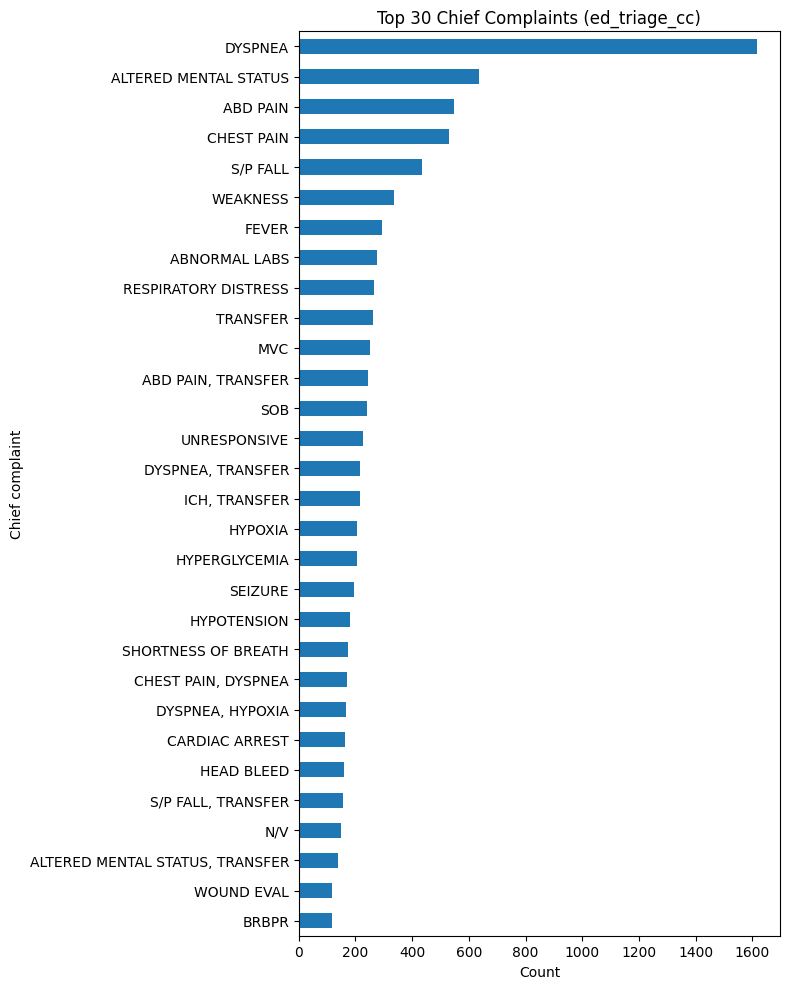

         chief_complaint  count
0                DYSPNEA   1617
1  ALTERED MENTAL STATUS    635
2               ABD PAIN    546
3             CHEST PAIN    529
4               S/P FALL    436
5               WEAKNESS    336
6                  FEVER    293
7          ABNORMAL LABS    275
8   RESPIRATORY DISTRESS    266
9               TRANSFER    262


In [9]:
import matplotlib.pyplot as plt

def top_cc_plot(
    df,
    candidates=('ed_triage_cc','chief_complaint','ed_chief_complaint','chiefcomplaint','cc'),
    top_n=30,
    normalize_case='upper'  # {'upper','title',None}
):
    cc_col = next((c for c in candidates if c in df.columns), None)
    if cc_col is None:
        raise KeyError(f"No chief-complaint column found in {candidates}.")

    s = (df[cc_col]
         .astype(str)
         .str.strip()
         .str.replace(r'\s+', ' ', regex=True))

    if normalize_case == 'upper':
        s = s.str.upper()
    elif normalize_case == 'title':
        s = s.str.title()

    vc = s.value_counts().head(top_n)
    vc = vc.sort_values(ascending=True)

    ax = vc.plot(kind='barh', figsize=(8, 10))
    ax.set_xlabel('Count')
    ax.set_ylabel('Chief complaint')
    ax.set_title(f'Top {top_n} Chief Complaints ({cc_col})')
    plt.tight_layout()
    plt.show()

    # also return the frequency table for programmatic use
    return vc.sort_values(ascending=False).rename_axis('chief_complaint').reset_index(name='count')

# usage:
freq_table = top_cc_plot(df, top_n=30, normalize_case='upper')
print(freq_table.head(10))

In [10]:
# --- Core dependencies and model ---
import re, sys, subprocess, importlib
import numpy as np
import pandas as pd

def _ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        importlib.invalidate_caches()

_ensure("ftfy")
_ensure("symspellpy")
_ensure("spacy")

import ftfy, spacy
from symspellpy.symspellpy import SymSpell, Verbosity

# spaCy model
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])

# --- Config & curated overrides (minimal, extend as you like) ---
CC_CANDIDATES = (
    "ed_triage_cc","chief_complaint","ed_chief_complaint",
    "chiefcomplaint","chief_complaint_text","ed_cc","cc"
)

def get_cc_column(df: pd.DataFrame) -> str:
    for c in CC_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"No chief-complaint column found in {CC_CANDIDATES}.")

PROTECT = ("n/v","n/v/d","s/p","w/","w/o","h/o","c/o")
MISSING_RE = re.compile(r"^(?:n/?a|na|none|unknown|unk|no chief complaint|no complaint|not applicable|not available)$", re.I)
NEG_RE     = re.compile(r"^(?:denies?|no|not|without|w/o)\b", re.I)

# curated segment- and token-level overrides
SEG_OVR = {
    "n/v":"nausea vomiting",
    "n/v/d":"nausea vomiting diarrhea",
    "nvd":"nausea vomiting diarrhea",
    "w/":"with", "w/o":"without", "s/p":"status post", "h/o":"history of", "c/o":"complains of",
    "mva":"motor vehicle accident", "mvc":"motor vehicle collision",
    "ped vs auto":"pedestrian struck by vehicle", "gsw":"gunshot wound",
    "sa":"sexual assault",
}
TOK_OVR = {
    # cardiopulmonary
    "sob":"shortness of breath","doe":"dyspnea on exertion","cp":"chest pain","palps":"palpitations",
    # neuro
    "ha":"headache","loc":"loss of consciousness","ams":"altered mental status",
    "sz":"seizure","szs":"seizure","cva":"stroke","tia":"transient ischemic attack",
    # gi/gu
    "abd":"abdominal", "abdo":"abdominal", "rlq":"right lower quadrant","ruq":"right upper quadrant",
    "llq":"left lower quadrant","luq":"left upper quadrant",
    "lbp":"low back pain","brbpr":"rectal bleeding",
    "uti":"urinary tract infection","dysuria":"painful urination","hematuria":"blood in urine",
    "nv":"nausea vomiting","nvd":"nausea vomiting diarrhea",
    # respiratory / infectious
    "sorethroat":"sore throat","uri":"upper respiratory infection","pna":"pneumonia","covid":"covid","flu":"influenza",
    # psych/substance
    "si":"suicidal ideation","hi":"homicidal ideation","avh":"auditory visual hallucinations",
    "etoh":"alcohol","od":"overdose","fb":"foreign body",
    # ob/gyn
    "vag":"vaginal","vb":"vaginal bleeding","hg":"hyperemesis gravidarum",
    # keep slash forms usable inside segments too
    "s/p":"status post","w/":"with","w/o":"without","h/o":"history of","c/o":"complains of",
    "n/v":"nausea vomiting","n/v/d":"nausea vomiting diarrhea",
}
# context overrides (eye vs overdose)
CTX_OVR = {
    "od": (lambda seg: not re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "overdose", "right eye"),
    "os": (lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "left eye", None),
    "ou": (lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "both eyes", None),
}

# optional external abbreviation inventory; keep empty if offline
abbr_map: dict[str,str] = {}

# --- SymSpell (lightweight lexicon) ---
sym = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
def _add_lexicon_from_phrases(phrases):
    for ph in phrases:
        for w in str(ph).split():
            if w.isalpha():
                sym.create_dictionary_entry(w, 1)

_add_lexicon_from_phrases(list(SEG_OVR.values()) + list(TOK_OVR.values()) + list(abbr_map.values()))

SAFE_2CHAR = {"cp","ha","nv","gi","gu","ms","sx","bp","hr","doe","sob","loc"}

def _spell(tok: str) -> str:
    if len(tok) <= 3 and tok not in SAFE_2CHAR:
        return tok
    if not tok.isalpha():
        return tok
    cand = sym.lookup(tok, Verbosity.CLOSEST, max_edit_distance=2)
    return cand[0].term if cand else tok

# --- Token/segment helpers used by normalize_cc ---
_PUNCT_EDGE = re.compile(r"(^[^\w/]+)|([^\w/]+$)")
def _clean_tok(tok: str) -> str:
    return _PUNCT_EDGE.sub("", tok)

def _expand_tokens(seg: str) -> str:
    """Contextual → curated → inventory token expansion inside a segment."""
    out = []
    seg_for_ctx = seg
    for tok in seg.split():
        t = _clean_tok(tok)
        if not t: 
            continue
        if t in CTX_OVR:
            pred, yes, no = CTX_OVR[t]
            if pred(seg_for_ctx):
                out.extend(yes.split()); continue
            if no:
                out.extend(no.split()); continue
        if t in TOK_OVR:
            out.extend(TOK_OVR[t].split()); continue
        if t in abbr_map:
            out.extend(abbr_map[t].split()); continue
        out.append(t)
    return " ".join(out)

# conditional split on "and" only when both sides look clinical
CLINICAL_KEYS = {
    "pain","fever","chill","cough","wheez","dyspnea","shortness","hemopty",
    "nausea","vomit","diarrhea","bleeding","rash","injury","wound","laceration","fracture",
    "sprain","assault","fall","seizure","syncope","weakness","numbness","tingling","headache",
    "dizziness","palpitation","chest","abdominal","flank","pelvic","back","neck","urinary",
    "dysuria","hematuria","pregnan","vaginal","overdose","intoxication","anxiety","depression",
    "psychosis","sore","throat","ear","eye","dental","asthma","copd","flu","covid","pneumonia"
}
def _looks_clinical(s: str) -> bool:
    s = s.lower()
    return any(k in s for k in CLINICAL_KEYS) and re.search(r"[a-z]", s)

def _split_on_and_if_clinical(seg: str) -> list[str]:
    parts = [p.strip() for p in re.split(r"\band\b", seg, flags=re.I)]
    if len(parts) == 1:
        return parts
    out, buf = [], parts[0]
    for nxt in parts[1:]:
        if _looks_clinical(buf) and _looks_clinical(nxt):
            out.append(buf.strip()); buf = nxt
        else:
            buf = f"{buf} and {nxt}"
    out.append(buf.strip())
    return out

# duration patterns: sobx2d, sob x 2 d, x3w, x2 months, etc.
_DUR_RE = re.compile(r"\b([a-z]{2,})\s*x\s*(\d{1,3})\s*([dhwm]|day|hr|hour|wk|week|mo|mon|month|yr|year)s?\b", re.I)
_UNIT = {
    "d":"days","day":"days","h":"hours","hr":"hours","hour":"hours",
    "w":"weeks","wk":"weeks","week":"weeks","m":"months","mo":"months","mon":"months",
    "y":"years","yr":"years","year":"years"
}
def _expand_duration(seg: str) -> str:
    def repl(m):
        base = m.group(1)
        n = m.group(2)
        key = m.group(3).lower()
        key = key[0]  # map by first letter via _UNIT
        return f"{base} for {n} {_UNIT.get(key,'')}".strip()
    return _DUR_RE.sub(repl, seg)

# primary splitter: separators ; , + &
SEP_SPLIT_RE = re.compile(r"\s*(?:[;:,]|[+&])\s*")

def segment_cc(raw: str, keep_negated: bool=False) -> list[str]:
    if not isinstance(raw, str) or not raw.strip():
        return []
    txt = ftfy.fix_text(raw).lower().strip()

    # Protect canonical slash tokens
    for p in PROTECT:
        txt = txt.replace(p, p.replace("/", "§"))

    # Normalize spaced variants so they become protected too
    txt = re.sub(r"\bn\s*/\s*v\s*/\s*d\b", "n§v§d", txt)  # n / v / d
    txt = re.sub(r"\bn\s*/\s*v\b",         "n§v",    txt)  # n / v
    txt = re.sub(r"\bs\s*/\s*p\b",         "s§p",    txt)  # s / p
    txt = re.sub(r"\bw\s*/\s*o\b",         "w§o",    txt)  # w / o
    txt = re.sub(r"\bh\s*/\s*o\b",         "h§o",    txt)  # h / o
    txt = re.sub(r"\bc\s*/\s*o\b",         "c§o",    txt)  # c / o

    # Split on any remaining slashes (true separators)
    txt = txt.replace("/", "; ")
    # <<< END INSERT >>>

    segs = []
    for block in SEP_SPLIT_RE.split(txt):
        if not block:
            continue
        block = block.replace("§", "/").strip()
        block = " ".join(block.split())
        if MISSING_RE.fullmatch(block):
            continue
        for seg in _split_on_and_if_clinical(block):
            if not seg:
                continue
            if not keep_negated and NEG_RE.match(seg):
                continue
            # drop single-letter noise like 'n','v','d' if they slipped through
            if re.fullmatch(r"[a-z]$", seg):
                continue
            segs.append(seg)
    return segs

def normalize_cc(raw: str, keep_negated: bool=False) -> list[str]:
    out, seen = [], set()
    for seg in segment_cc(raw, keep_negated=keep_negated):
        if seg in SEG_OVR:
            seg = SEG_OVR[seg]
        else:
            toks = seg.split()
            if len(toks) == 1:
                t = _clean_tok(toks[0])
                if t in TOK_OVR:
                    seg = TOK_OVR[t]
                else:
                    seg = abbr_map.get(seg, seg)
        seg = _expand_duration(seg)
        seg = _expand_tokens(seg)
        toks = [_spell(t) for t in seg.split()]
        seg = " ".join(t.lemma_ for t in nlp(" ".join(toks))).strip()
        if seg and seg not in seen:
            out.append(seg); seen.add(seg)
    return out

print("CC normalization stack ready.")

CC normalization stack ready.


In [11]:
# --- Deterministic RFV mapper (top-level groups) ---
from dataclasses import dataclass

PRECEDENCE = [
    "injury","resp","circ","neuro","gi","gu","msk","skin","eye_ear",
    "general","psych","disease","abn_test","screen","treatment","admin","uncodable"
]

@dataclass(frozen=True)
class Rule:
    group: str
    rx: re.Pattern

RULES = [
    Rule("injury", re.compile(r"\b(mvc|mva|collision|assault|fall|gsw|gunshot|stab|laceration|fracture|burn|overdose|poison|foreign body|fb)\b")),
    Rule("resp", re.compile(r"\b(shortness of breath|dyspnea|doe|wheeze|cough|hemoptysis|respiratory distress)\b")),
    Rule("circ", re.compile(r"\b(chest pain|(?:^|[^a-z])cp(?:[^a-z]|$)|palpitation|hypotension|low bp|edema|leg swelling|ankle swelling)\b")),
    Rule("neuro", re.compile(r"\b(headache|migraine|dizziness|syncope|weakness|numbness|tingling|seizure|altered mental status|ams|slurred speech|aphasia|facial droop)\b")),
    Rule("gi", re.compile(r"\b(abd(ominal)? pain|rlq|ruq|llq|luq|nausea|vomit|diarrhea|constipation|rectal bleeding|hematemesis|jaundice)\b")),
    Rule("gu", re.compile(r"\b(dysuria|hematuria|frequency|urgency|flank pain|pelvic pain|vaginal (bleeding|discharge)|penile discharge)\b")),
    Rule("msk", re.compile(r"\b(back pain|neck pain|shoulder pain|knee pain|hip pain|joint pain|arm pain|leg pain|gait)\b")),
    Rule("skin", re.compile(r"\b(rash|cellulitis|abscess|wound(?! check))\b")),
    Rule("eye_ear", re.compile(r"\b(eye pain|red eye|vision change|ear pain|hearing change|otitis|conjunctivitis)\b")),
    Rule("general", re.compile(r"\b(fever|chills|fatigue|malaise|weakness(?!.*focal))\b")),
    Rule("psych", re.compile(r"\b(anxiety|depression|insomnia|suicidal ideation|homicidal ideation|si|hi|psychosis|agitation)\b")),
    Rule("disease", re.compile(r"\b(asthma attack|copd flare|covid(?! test)|diabetes(?!.*test)|pneumonia|hypertensive crisis|stroke)\b")),
    Rule("abn_test", re.compile(r"\b(abnormal (lab|ecg|ekg|imaging)|told.*(abnormal|positive)|positive (strep|flu|covid) (result|test))\b")),
    Rule("screen", re.compile(r"\b(covid test|flu test|strep test|bp check|pregnancy test|workup|screen(ing)?)\b")),
    Rule("treatment", re.compile(r"\b(refill|medication refill|wound check|suture removal|dressing change|injection|detox clearance)\b")),
    Rule("admin", re.compile(r"\b(form|paperwork|note|letter|clearance|work (note|letter))\b")),
]

def assign_rfv(segments: list[str], max_rfv: int = 5):
    hits = []
    for i, seg in enumerate(segments):
        seg_l = " " + seg.lower() + " "
        for rule in RULES:
            if rule.rx.search(seg_l):
                hits.append((rule.group, i, seg))
                break
    # keep first support per group; order by precedence then text position
    first_support = {}
    for g, i, s in hits:
        first_support.setdefault(g, (i, s))
    ordered = sorted(first_support.items(), key=lambda kv: (PRECEDENCE.index(kv[0]), kv[1][0]))[:max_rfv]
    return [{"group": g, "support": first_support[g][1]} for g, _ in ordered]

print("RFV rules ready.")

RFV rules ready.


In [12]:
cc_col = get_cc_column(df)                      # prefers ed_triage_cc
df["cc_cleaned"] = df[cc_col].apply(normalize_cc)
df["cc_cleaned_str"] = df["cc_cleaned"].str.join("; ")

def map_row_to_rfv(row):
    segs = row["cc_cleaned"]
    rfv = assign_rfv(segs)
    out = {f"RFV{i+1}": (rfv[i]["group"] if i < len(rfv) else "") for i in range(5)}
    out.update({f"RFV{i+1}_support": (rfv[i]["support"] if i < len(rfv) else "") for i in range(5)})
    return pd.Series(out)

rfv_cols = df.apply(map_row_to_rfv, axis=1)
df = pd.concat([df, rfv_cols], axis=1)

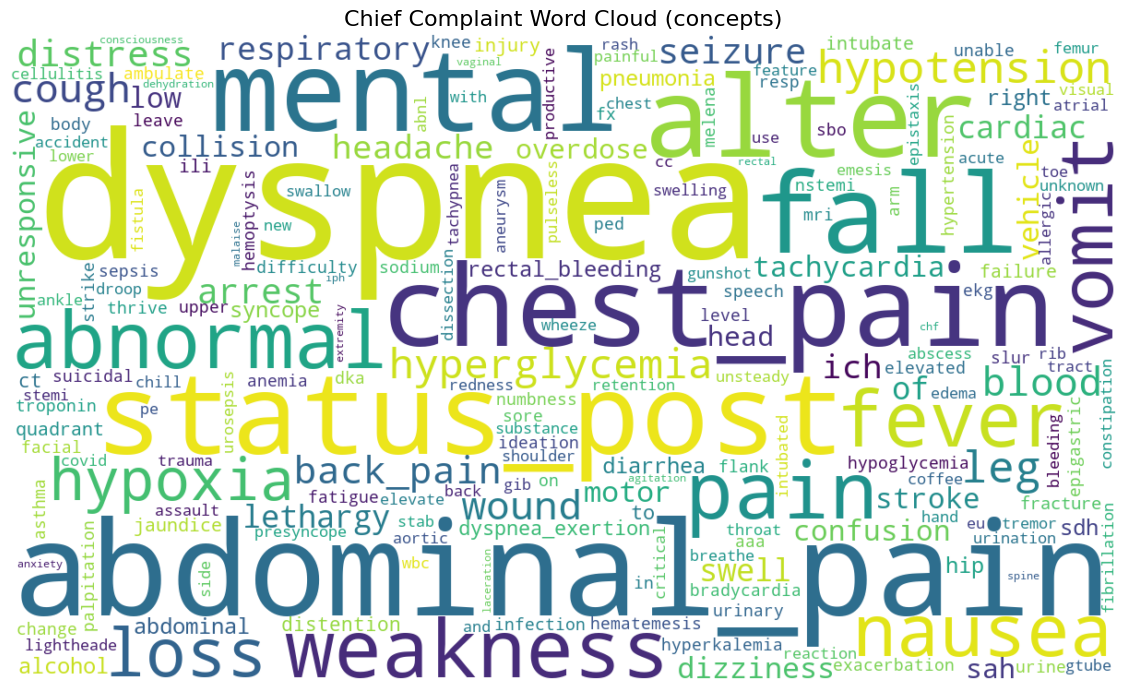

In [13]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Concept-level replacements applied AFTER normalize_cc()
CANON_REPLACERS = [
    (re.compile(r"\bshortness of breath\b", flags=re.I), "dyspnea"),
    (re.compile(r"\bdyspneic?\b", flags=re.I),           "dyspnea"),
    (re.compile(r"\bdyspnea on exertion\b", flags=re.I), "dyspnea_exertion"),
]

# Optional: reduce noise from s/p
CANON_REPLACERS += [
    (re.compile(r"\bstatus post\b", flags=re.I), "status_post"),
]

def canonize_cc_segments(segments):
    if not isinstance(segments, list): 
        return segments
    out = []
    for seg in segments:
        t = seg
        for rx, rep in CANON_REPLACERS:
            t = rx.sub(rep, t)
        out.append(t)
    return out

# Apply on top of your existing cc_cleaned
df["cc_cleaned_canon"] = df["cc_cleaned"].apply(canonize_cc_segments)
df["cc_cleaned_canon_str"] = df["cc_cleaned_canon"].str.join("; ")



# Phrases to preserve in the cloud (add freely)
PHRASE_JOIN = [
    (re.compile(r"\baltered mental status\b", re.I), "altered_mental_status"),
    (re.compile(r"\bchest pain\b", re.I),            "chest_pain"),
    (re.compile(r"\babdominal pain\b", re.I),        "abdominal_pain"),
    (re.compile(r"\brectal bleeding\b", re.I),       "rectal_bleeding"),
    (re.compile(r"\bback pain\b", re.I),             "back_pain"),
    (re.compile(r"\bdyspnea\b", re.I),               "dyspnea"),             # concept token
    (re.compile(r"\bdyspnea_exertion\b", re.I),      "dyspnea_exertion"),
    (re.compile(r"\bstatus post\b", re.I),           "status_post"),         # optional
]

# Lightweight stoplist for visualization-only noise
CLOUD_STOP = {"status", "post", "transfer", "eval", "evaluation"}

def concept_frequencies(segments_series, lowercase=True):
    freq = Counter()
    for segs in segments_series:
        if not isinstance(segs, list): 
            continue
        for s in segs:
            # phrase joining
            for rx, repl in PHRASE_JOIN:
                s = rx.sub(repl, s)
            txt = s.lower() if lowercase else s
            # tokenize letters/underscores only
            for tok in re.findall(r"[a-zA-Z_]+", txt):
                if tok in CLOUD_STOP or len(tok) < 2:
                    continue
                freq[tok] += 1
    return freq

# Build frequencies from the canonicalized segments
freq = concept_frequencies(df["cc_cleaned_canon"])

# Word cloud that respects the joined phrases and concepts
wc = WordCloud(width=1200, height=700, background_color="white")
wc = wc.generate_from_frequencies(freq)

plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Chief Complaint Word Cloud (concepts)", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
import re, json, math
from dataclasses import dataclass
from collections import defaultdict, Counter

import torch
import pandas as pd
from sentence_transformers import SentenceTransformer, util

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "NeuML/bioclinical-modernbert-base-embeddings"  # SentenceTransformers-ready

encoder = SentenceTransformer(MODEL_NAME, device=DEVICE, trust_remote_code=True)

/opt/anaconda3/envs/mimiciv-tabular/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import torch
from sentence_transformers import util

APPX = Path("/Users/reblocke/Research/Hypercap-CC-NLP/Annotation/nhamcs_rvc_2022_appendixII_codes.csv")
SUMM = Path("/Users/reblocke/Research/Hypercap-CC-NLP/Annotation/nhamcs_rvc_2022_summary_by_top_level_17.csv")

# --- 17-group canon (same keys you already use) ---
RVC_NAME = {
    "RVC-INJ":"Injuries & adverse effects","RVC-SYM-RESP":"Symptom – Respiratory",
    "RVC-SYM-CIRC":"Symptom – Circulatory","RVC-SYM-NERV":"Symptom – Nervous",
    "RVC-SYM-DIG":"Symptom – Digestive","RVC-SYM-GU":"Symptom – Genitourinary",
    "RVC-SYM-MSK":"Symptom – Musculoskeletal","RVC-SYM-SKIN":"Symptom – Skin/Hair/Nails",
    "RVC-SYM-EYE":"Symptom – Eye/Ear","RVC-SYM-GEN":"Symptom – General",
    "RVC-SYM-PSY":"Symptom – Psychological","RVC-DIS":"Diseases (patient‑stated)",
    "RVC-TEST":"Abnormal test result","RVC-DIAG":"Diagnostic/Screening/Preventive",
    "RVC-TREAT":"Treatment/Medication","RVC-ADMIN":"Administrative","RVC-UNCL":"Uncodable/Unknown"
}

PRECEDENCE = [
    "RVC-INJ","RVC-SYM-RESP","RVC-SYM-CIRC","RVC-SYM-NERV","RVC-SYM-DIG",
    "RVC-SYM-GU","RVC-SYM-MSK","RVC-SYM-SKIN","RVC-SYM-EYE","RVC-SYM-GEN",
    "RVC-SYM-PSY","RVC-DIS","RVC-TEST","RVC-DIAG","RVC-TREAT","RVC-ADMIN","RVC-UNCL"
]  # NHAMCS ladder; used elsewhere too.  [oai_citation:2‡Annotators Guide v0.3 MIMIC IV Chief Complaint to NHAMCS RVS.docx](sediment://file_000000007a1c61f6b6fe2292fdae9011)

# --- Heuristics to detect columns in your spreadsheets ---
def _guess_col(cols, candidates):
    low = [c.lower().strip() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    return None

# --- Canonicalization / filtering for Appendix II phrases ---
RE_DROP = re.compile(r"\b(nec|nos|unspecified|other|other and unspecified)\b", re.I)
RE_SPACE = re.compile(r"\s+")
def canon_phrase(s: str) -> str:
    s = str(s).strip()
    s = s.replace("’","'").replace("–","-")
    s = RE_SPACE.sub(" ", s)
    s = s.strip(" .;:,")
    return s

def keep_phrase(s: str, group_code: str) -> bool:
    txt = s.lower()
    if len(txt) < 3: return False
    if RE_DROP.search(txt): return False
    # Filter body-part only entries unless in INJ/MSK/EYE/SKIN where site may carry signal
    if group_code not in {"RVC-INJ","RVC-SYM-MSK","RVC-SYM-EYE","RVC-SYM-SKIN"}:
        if re.fullmatch(r"(arm|leg|back|knee|hip|wrist|elbow|ankle|hand|foot|toe|finger|eye|ear)", txt):
            return False
    return True

# --- Map a free-text group label to your 17 keys (robust) ---
GROUP_MAP = [
    (re.compile(r"\binjur|poison|overdose|adverse effect", re.I), "RVC-INJ"),
    (re.compile(r"\brespir", re.I), "RVC-SYM-RESP"),
    (re.compile(r"\bcircul|cardio|lymph", re.I), "RVC-SYM-CIRC"),
    (re.compile(r"\bnerv|neuro", re.I), "RVC-SYM-NERV"),
    (re.compile(r"\bdigest|gastro|abd", re.I), "RVC-SYM-DIG"),
    (re.compile(r"\bgenitour|urinar|renal|pelvic|vagin|penil|breast", re.I), "RVC-SYM-GU"),
    (re.compile(r"\bmusculoskelet|msk|joint|back|neck", re.I), "RVC-SYM-MSK"),
    (re.compile(r"\bskin|hair|nail|derma", re.I), "RVC-SYM-SKIN"),
    (re.compile(r"\beye|ear|vision|hearing|vertigo", re.I), "RVC-SYM-EYE"),
    (re.compile(r"\bgeneral|fever|malaise|weakness", re.I), "RVC-SYM-GEN"),
    (re.compile(r"\bpsych|mental", re.I), "RVC-SYM-PSY"),
    (re.compile(r"\bdisease|diagnos|known|asthma|copd|diabetes|hypertens|pneumonia|stroke", re.I), "RVC-DIS"),
    (re.compile(r"\babnormal .*test|abnormal (lab|imaging|ekg|ecg)|positive (test|culture|result)", re.I), "RVC-TEST"),
    (re.compile(r"\bscreen|diagnostic|prenatal|immuniz|vaccine|bp check|test\b", re.I), "RVC-DIAG"),
    (re.compile(r"\btreat|medicat|refill|suture|dressing|injection|therapy|wound check", re.I), "RVC-TREAT"),
    (re.compile(r"\badmin|paperwork|form|clearance|insurance|work (note|letter)", re.I), "RVC-ADMIN"),
    (re.compile(r"\buncodable|unknown|illegible|none", re.I), "RVC-UNCL"),
]

def map_group(label: str) -> str|None:
    for rx, code in GROUP_MAP:
        if rx.search(str(label)):
            return code
    return None

# --- Load Appendix II and Summary files robustly ---
# map RVC display label -> code (normalize whitespace and dashes)
def _norm_label(s: str) -> str:
    s = (s or "").strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    return s

LABEL2CODE = { _norm_label(v): k for k, v in RVC_NAME.items() }

def _label_to_code(label: str) -> str|None:
    lab = _norm_label(label)
    if lab in LABEL2CODE:
        return LABEL2CODE[lab]
    # fallback to regex mapping if a label differs slightly
    return map_group(label)

def load_appendix_phrases(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"NOTE: Appendix not found at {path}; proceeding with curated seeds only.")
        return pd.DataFrame(columns=["group_code","phrase"])

    df = pd.read_csv(path, dtype=str)

    # Use the known columns
    if not {"top_level_group17","text"}.issubset(df.columns):
        # fall back to the generic heuristic if needed
        gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"]) or "group"
        pcol = _guess_col(df.columns, ["text","phrase","subentry","entry","label"]) or "text"
    else:
        gcol, pcol = "top_level_group17", "text"

    df = df[[gcol, pcol]].rename(columns={gcol:"group_raw", pcol:"phrase_raw"})
    df["group_code"] = df["group_raw"].map(_label_to_code)
    df = df[df["group_code"].notna()]

    df["phrase"] = df["phrase_raw"].map(canon_phrase)
    df = df[df.apply(lambda r: keep_phrase(r["phrase"], r["group_code"]), axis=1)]
    return df[["group_code","phrase"]].drop_duplicates()

def load_summary_weights(path: Path, strategy: str = "uniform") -> dict[str, float]:
    """
    strategy: 'uniform' or 'by_rows'
      - 'uniform': all groups weight=1.0
      - 'by_rows': weight ∝ number of rows in this file per group (proxy, not prevalence)
    """
    if not path.exists():
        return {}
    df = pd.read_csv(path, dtype=str)

    # Robust group column detection
    gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"])
    if not gcol:
        # fall back to first col if nothing matched
        gcol = df.columns[0]

    if strategy == "by_rows":
        w = df.groupby(gcol).size()
    else:
        # uniform
        w = df.groupby(gcol).size()
        w[:] = 1.0

    # log-scale and normalize to [~0,1]
    w = (np.log1p(w) / np.log1p(w).max()).to_dict()
    return w

appx_df = load_appendix_phrases(APPX) if APPX.exists() else pd.DataFrame(columns=["group_code","phrase"])
group_weights = load_summary_weights(SUMM)

# --- Start with your curated prototypes, then augment from Appendix II ---
RVC_PROTOS_CURATED = {
    "RVC-INJ": [
        "injury: laceration cut", "injury: fracture", "injury: burn", "injury: contusion bruise",
        "injury: foreign body", "injury: motor vehicle collision", "injury: fall",
        "adverse effect: medication reaction", "poisoning overdose", "injury: assault", "gunshot wound",
    ],
    "RVC-SYM-RESP": [
        "respiratory symptom: shortness of breath dyspnea", "respiratory symptom: dyspnea on exertion",
        "respiratory symptom: wheeze", "respiratory symptom: cough", "respiratory symptom: hemoptysis",
        "respiratory symptom: sputum production", "respiratory symptom: respiratory distress",
    ],
    "RVC-SYM-CIRC": [
        "circulatory symptom: chest pain suspected cardiac", "circulatory symptom: palpitations",
        "circulatory symptom: hypotension low blood pressure", "circulatory symptom: bradycardia",
        "circulatory symptom: tachycardia", "circulatory symptom: peripheral edema leg swelling ankle swelling",
        "circulatory symptom: claudication",
    ],
    "RVC-SYM-NERV": [
        "neurologic symptom: altered mental status confusion", "neurologic symptom: lethargy decreased responsiveness",
        "neurologic symptom: slurred speech dysarthria", "neurologic symptom: aphasia word finding difficulty",
        "neurologic symptom: facial droop", "neurologic symptom: syncope fainting", "neurologic symptom: seizure",
        "neurologic symptom: headache", "neurologic symptom: dizziness vertigo",
        "neurologic symptom: numbness tingling focal weakness",
    ],
    "RVC-SYM-DIG": [
        "digestive symptom: abdominal pain", "digestive symptom: nausea vomiting", "digestive symptom: diarrhea",
        "digestive symptom: rectal bleeding", "digestive symptom: dysphagia", "digestive symptom: jaundice",
    ],
    "RVC-SYM-GU": [
        "genitourinary symptom: dysuria painful urination", "genitourinary symptom: urinary frequency urgency",
        "genitourinary symptom: hematuria blood in urine", "genitourinary symptom: flank pain",
        "genitourinary symptom: pelvic pain", "genitourinary symptom: vaginal discharge",
    ],
    "RVC-SYM-MSK": [
        "musculoskeletal symptom: back pain", "musculoskeletal symptom: neck pain", "musculoskeletal symptom: joint pain",
        "musculoskeletal symptom: hip knee shoulder pain", "musculoskeletal symptom: gait problem",
    ],
    "RVC-SYM-SKIN": [
        "skin symptom: rash", "skin symptom: pruritus itching", "skin symptom: cellulitis redness warmth",
        "skin symptom: nontraumatic wound",
    ],
    "RVC-SYM-EYE": [
        "eye symptom: eye pain", "eye symptom: red eye eye redness", "eye symptom: blurry vision vision loss",
        "ear symptom: ear pain discharge", "vestibular symptom: vertigo spinning",
    ],
    "RVC-SYM-GEN": [
        "general symptom: fever chills", "general symptom: fatigue malaise", "general symptom: weakness generalized",
        "general symptom: weight change", "general symptom: edema swelling",
    ],
    "RVC-SYM-PSY": [
        "psychological symptom: anxiety", "psychological symptom: depression", "psychological symptom: agitation",
        "psychological symptom: insomnia", "psychological symptom: suicidal ideation", "psychological symptom: homicidal ideation",
        "psychological symptom: substance intoxication without overdose",
    ],
    "RVC-DIS": [
        "patient stated diagnosis: asthma attack", "patient stated diagnosis: copd flare", "patient stated diagnosis: pneumonia",
        "patient stated diagnosis: diabetes problem", "patient stated diagnosis: hypertensive crisis", "patient stated diagnosis: stroke diagnosed",
    ],
    "RVC-TEST": [
        "abnormal test: abnormal laboratory result", "abnormal test: abnormal imaging result",
        "abnormal test: positive culture", "abnormal test: abnormal ecg ekg", "abnormal test: positive blood culture",
    ],
    "RVC-DIAG": [
        "diagnostic screening: needs covid test", "diagnostic screening: blood pressure check",
        "diagnostic screening: routine testing screening", "diagnostic screening: prenatal check",
    ],
    "RVC-TREAT": [
        "treatment medication: prescription refill", "treatment medication: dressing change",
        "treatment medication: injection therapy", "treatment medication: suture removal", "treatment: wound check",
    ],
    "RVC-ADMIN": [
        "administrative reason: work form school form insurance paperwork", "administrative reason: clearance note",
    ],
    "RVC-UNCL": [
        "uncodable or unknown reason"
    ],
}
# Ensure every group exists (defensive)
for g in RVC_NAME:
    RVC_PROTOS_CURATED.setdefault(g, [])

# --- Merge curated seeds + Appendix II phrases ---
RVC_PROTOS_AUG = {g: list(v) for g,v in RVC_PROTOS_CURATED.items()}
for g, subdf in appx_df.groupby("group_code"):
    RVC_PROTOS_AUG[g].extend(subdf["phrase"].tolist())


# --- Deduplicate near-duplicates using embeddings (cosine > 0.92 collapses) ---
def dedup_prototypes(rvc_protos: dict[str,list[str]], sim_thresh: float = 0.92) -> dict[str,list[str]]:
    out = {}
    for g, phrases in rvc_protos.items():
        phrases = [canon_phrase(p) for p in phrases]
        phrases = sorted(list(dict.fromkeys(phrases)))  # exact dedup, stable order
        if not phrases:
            out[g] = []
            continue
        with torch.inference_mode():
            emb = encoder.encode(phrases, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)
        keep = []
        taken = torch.zeros(len(phrases), dtype=torch.bool)
        for i in range(len(phrases)):
            if taken[i]: continue
            keep.append(phrases[i])
            if len(phrases) == 1: break
            # mark near-duplicates
            sims = util.cos_sim(emb[i:i+1], emb).squeeze(0).cpu().numpy()
            dup_idx = np.where(sims >= sim_thresh)[0]
            taken[dup_idx] = True
        out[g] = keep
    return out

RVC_PROTOS_FINAL = dedup_prototypes(RVC_PROTOS_AUG, sim_thresh=0.92)

# --- Encode final prototypes once; also compute optional weights per-prototype ---
ALL_PROTO_TEXTS, PROTO2CODE = [], []
for code, plist in RVC_PROTOS_FINAL.items():
    for p in plist:
        # Make short descriptors more uniform for embedding space
        if ":" in p:
            text = p
        else:
            # prefix with group cue (helps ModernBERT slightly)
            prefix = RVC_NAME[code].split("–")[0].strip()
            text = f"{prefix.lower()}: {p}"
        ALL_PROTO_TEXTS.append(text)
        PROTO2CODE.append(code)

with torch.inference_mode():
    PROTO_EMB = encoder.encode(ALL_PROTO_TEXTS, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)

# Optional: a weight per prototype = group prior * 1 (uniform inside group)
PROTO_WEIGHT = np.ones(len(PROTO2CODE), dtype="float32")
if group_weights:
    for i, g in enumerate(PROTO2CODE):
        PROTO_WEIGHT[i] = max(1e-3, float(group_weights.get(g, 1.0)))  # log-scaled prior

# Build index lists per group for scoring
from collections import defaultdict
CODE2PROTOIDX = defaultdict(list)
for i, code in enumerate(PROTO2CODE):
    CODE2PROTOIDX[code].append(i)

In [16]:
import re, numpy as np, pandas as pd, torch
from sentence_transformers import util
from collections import defaultdict

# ---------- helpers from your earlier block (unchanged) ----------
def _guess_col(cols, candidates):
    low = [c.lower().strip() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    return None

RE_DROP  = re.compile(r"\b(nec|nos|unspecified|other|other and unspecified)\b", re.I)
RE_SPACE = re.compile(r"\s+")
def canon_phrase(s: str) -> str:
    s = str(s).strip().replace("’","'").replace("–","-")
    s = RE_SPACE.sub(" ", s).strip(" .;:,")
    return s

def keep_phrase(s: str, group_code: str) -> bool:
    txt = s.lower()
    if len(txt) < 3: return False
    if RE_DROP.search(txt): return False
    if group_code not in {"RVC-INJ","RVC-SYM-MSK","RVC-SYM-EYE","RVC-SYM-SKIN"}:
        if re.fullmatch(r"(arm|leg|back|knee|hip|wrist|elbow|ankle|hand|foot|toe|finger|eye|ear)", txt):
            return False
    return True

GROUP_MAP = [
    (re.compile(r"\binjur|poison|overdose|adverse effect", re.I), "RVC-INJ"),
    (re.compile(r"\brespir", re.I), "RVC-SYM-RESP"),
    (re.compile(r"\bcircul|cardio|lymph", re.I), "RVC-SYM-CIRC"),
    (re.compile(r"\bnerv|neuro", re.I), "RVC-SYM-NERV"),
    (re.compile(r"\bdigest|gastro|abd", re.I), "RVC-SYM-DIG"),
    (re.compile(r"\bgenitour|urinar|renal|pelvic|vagin|penil|breast", re.I), "RVC-SYM-GU"),
    (re.compile(r"\bmusculoskelet|msk|joint|back|neck", re.I), "RVC-SYM-MSK"),
    (re.compile(r"\bskin|hair|nail|derma", re.I), "RVC-SYM-SKIN"),
    (re.compile(r"\beye|ear|vision|hearing|vertigo", re.I), "RVC-SYM-EYE"),
    (re.compile(r"\bgeneral|fever|malaise|weakness", re.I), "RVC-SYM-GEN"),
    (re.compile(r"\bpsych|mental", re.I), "RVC-SYM-PSY"),
    (re.compile(r"\bdisease|diagnos|known|asthma|copd|diabetes|hypertens|pneumonia|stroke", re.I), "RVC-DIS"),
    (re.compile(r"\babnormal .*test|abnormal (lab|imaging|ekg|ecg)|positive (test|culture|result)", re.I), "RVC-TEST"),
    (re.compile(r"\bscreen|diagnostic|prenatal|immuniz|vaccine|bp check|test\b", re.I), "RVC-DIAG"),
    (re.compile(r"\btreat|medicat|refill|suture|dressing|injection|therapy|wound check", re.I), "RVC-TREAT"),
    (re.compile(r"\badmin|paperwork|form|clearance|insurance|work (note|letter)", re.I), "RVC-ADMIN"),
    (re.compile(r"\buncodable|unknown|illegible|none", re.I), "RVC-UNCL"),
]
def map_group(label: str) -> str|None:
    for rx, code in GROUP_MAP:
        if rx.search(str(label)): return code
    return None

def load_appendix_phrases(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"NOTE: Appendix not found at {path}; proceeding with curated seeds only.")
        return pd.DataFrame(columns=["group_code","phrase"])
    df = pd.read_csv(path, dtype=str)
    gcol = _guess_col(df.columns, ["group","top_level_group","rvc_group","module"]) or "group"
    pcol = _guess_col(df.columns, ["phrase","subentry","entry","text","label"]) or "phrase"
    df = df[[gcol,pcol]].rename(columns={gcol:"group_raw", pcol:"phrase_raw"})
    df["group_code"] = df["group_raw"].map(map_group)
    df = df[df["group_code"].notna()]
    df["phrase"] = df["phrase_raw"].map(canon_phrase)
    df = df[df.apply(lambda r: keep_phrase(r["phrase"], r["group_code"]), axis=1)]
    return df[["group_code","phrase"]].drop_duplicates()

def load_summary_weights(path: Path, strategy: str = "uniform") -> dict[str, float]:
    """
    strategy: 'uniform' or 'by_rows'
      - 'uniform': all groups weight=1.0
      - 'by_rows': weight ∝ number of rows in this file per group (proxy, not prevalence)
    """
    if not path.exists():
        return {}
    df = pd.read_csv(path, dtype=str)

    # Robust group column detection
    gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"])
    if not gcol:
        # fall back to first col if nothing matched
        gcol = df.columns[0]

    if strategy == "by_rows":
        w = df.groupby(gcol).size()
    else:
        # uniform
        w = df.groupby(gcol).size()
        w[:] = 1.0

    # log-scale and normalize to [~0,1]
    w = (np.log1p(w) / np.log1p(w).max()).to_dict()
    return w

# Merge curated + appendix
appx_df       = load_appendix_phrases(APPX)
group_weights = load_summary_weights(SUMM, strategy="uniform")  # or 'by_rows'

RVC_PROTOS_AUG = {g: list(v) for g, v in RVC_PROTOS_CURATED.items()}
for g, sub in appx_df.groupby("group_code"):
    RVC_PROTOS_AUG[g].extend(sub["phrase"].tolist())

# Deduplicate per group using embeddings
def dedup_prototypes(rvc_protos: dict[str,list[str]], sim_thresh=0.92):
    out = {}
    for g, phrases in rvc_protos.items():
        phrases = sorted(list(dict.fromkeys(canon_phrase(p) for p in phrases)))
        if not phrases:
            out[g] = []
            continue
        with torch.inference_mode():
            emb = encoder.encode(phrases, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)
        keep, taken = [], torch.zeros(len(phrases), dtype=torch.bool)
        for i in range(len(phrases)):
            if taken[i]: continue
            keep.append(phrases[i])
            sims = util.cos_sim(emb[i:i+1], emb).squeeze(0).cpu().numpy()
            dup_idx = np.where(sims >= sim_thresh)[0]
            taken[dup_idx] = True
        out[g] = keep
    return out

RVC_PROTOS_FINAL = dedup_prototypes(RVC_PROTOS_AUG, sim_thresh=0.92)

# Encode final prototypes and build indices
ALL_PROTO_TEXTS, PROTO2CODE = [], []
for code, plist in RVC_PROTOS_FINAL.items():
    for p in plist:
        if ":" in p:
            text = p
        else:
            prefix = RVC_NAME[code].split("–")[0].strip().lower()
            text = f"{prefix}: {p}"
        ALL_PROTO_TEXTS.append(text)
        PROTO2CODE.append(code)

with torch.inference_mode():
    PROTO_EMB = encoder.encode(ALL_PROTO_TEXTS, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)

PROTO_WEIGHT = np.ones(len(PROTO2CODE), dtype="float32")
if group_weights:
    for i, g in enumerate(PROTO2CODE):
        PROTO_WEIGHT[i] = max(1e-3, float(group_weights.get(g, 1.0)))

from collections import defaultdict
CODE2PROTOIDX = defaultdict(list)
for i, code in enumerate(PROTO2CODE):
    CODE2PROTOIDX[code].append(i)

def sanity_prototypes():
    counts = {g: len(CODE2PROTOIDX.get(g, [])) for g in RVC_NAME}
    total  = sum(counts.values())
    print("prototype count by group:", counts)
    print("TOTAL prototypes:", total, "PROTO_EMB shape:", tuple(PROTO_EMB.shape))
    missing = [g for g,c in counts.items() if c == 0]
    assert not missing, f"Groups missing prototypes: {missing}"
    assert total >= 50, f"Too few prototypes ({total}). Check paths and seeds."

sanity_prototypes()

prototype count by group: {'RVC-INJ': 75, 'RVC-SYM-RESP': 7, 'RVC-SYM-CIRC': 7, 'RVC-SYM-NERV': 10, 'RVC-SYM-DIG': 6, 'RVC-SYM-GU': 6, 'RVC-SYM-MSK': 5, 'RVC-SYM-SKIN': 4, 'RVC-SYM-EYE': 5, 'RVC-SYM-GEN': 5, 'RVC-SYM-PSY': 6, 'RVC-DIS': 135, 'RVC-TEST': 4, 'RVC-DIAG': 12, 'RVC-TREAT': 54, 'RVC-ADMIN': 14, 'RVC-UNCL': 6}
TOTAL prototypes: 361 PROTO_EMB shape: (361, 768)


In [17]:
# Precompiled regex triggers per group
RX_FOCAL_WEAK = re.compile(
    r"\b(focal|left|right|arm|leg|hand|face|hemiparesis|hemiplegia).*\bweakness\b|\bweakness\b.*\b(focal|left|right|arm|leg|hand|face)\b",
    re.I
)

RX = {
    "RVC-INJ": re.compile(r"\b(mvc|mva|collision|ped(\s|)vs(\s|)auto|assault|fell|fall|gsw|gunshot|stab|laceration|fracture|burn|foreign body|poison(ing)?|overdose|od\b|adverse (drug|medication) reaction)\b", re.I),
    "RVC-SYM-RESP": re.compile(r"\b(shortness of breath|dyspnea|doe\b|wheeze|respiratory distress|cough(ing)?|hemoptysis|sputum)\b", re.I),
    "RVC-SYM-CIRC": re.compile(r"\b(chest pain|palpitation(s)?|hypotension|low bp|bradycardia|tachycardia|arrhythmia|irregular heartbeat|edema|leg swelling|ankle swelling|peripheral edema|claudication)\b", re.I),
    "RVC-SYM-NERV": re.compile(r"\b(alter(ed)? mental status|ams\b|confusion|letharg(y|ic)|unresponsive|syncope|faint(ing)?|seizure(s)?|slurred speech|dysarthria|aphasia|facial droop|headache|migraine|dizziness|vertigo|numbness|tingling)\b", re.I),
    "RVC-SYM-DIG":  re.compile(r"\b(abd(ominal)? pain|abdo pain|nausea|vomit(ting)?|diarrhea|rectal bleeding|hematemesis|dysphagia|jaundice)\b", re.I),
    "RVC-SYM-GU":   re.compile(r"\b(dysuria|hematuria|urinary (frequency|urgency)|flank pain|pelvic pain|vaginal (bleeding|discharge)|penile discharge)\b", re.I),
    "RVC-SYM-MSK":  re.compile(r"\b(back pain|neck pain|shoulder pain|knee pain|hip pain|joint pain|gait problem)\b", re.I),
    "RVC-SYM-SKIN": re.compile(r"\b(rash|pruritus|itch(ing)?|cellulitis|wound(?! check))\b", re.I),
    "RVC-SYM-EYE":  re.compile(r"\b(eye (pain|redness|irritation)|red eye|pink ?eye|conjunctivitis|blurry vision|vision (loss|change)|ear pain|hearing (loss|change)|tinnitus|ear discharge|vertigo)\b", re.I),
    "RVC-SYM-GEN":  re.compile(r"\b(fever|chills|fatigue|malaise|weakness(?!.*focal))\b", re.I),
    "RVC-SYM-PSY":  re.compile(r"\b(anxiety|depression|insomnia|agitation|suicidal ideation|homicidal ideation|si\b|hi\b|intoxication)\b", re.I),
    "RVC-DIS":      re.compile(r"\b(asthma attack|copd flare|pneumonia|diabetes(?!.*test)|hypertensive crisis|stroke diagnosed)\b", re.I),
    "RVC-TEST":     re.compile(r"\b(abnormal (lab|labs|imaging|ct|mri|x[- ]?ray|ekg|ecg)|told (to come|results?)|positive (test|culture|blood culture)|blood culture (positive|grew|growth))\b", re.I),
    "RVC-DIAG":     re.compile(r"\b((needs|for) (covid|flu|strep) test|screen(ing)?|bp (check|recheck)|workup|routine testing|prenatal)\b", re.I),
    "RVC-TREAT":    re.compile(r"\b(refill|prescription refill|rx refill|dressing change|suture removal|injection|detox clearance|wound check)\b", re.I),
    "RVC-ADMIN":    re.compile(r"\b(form|paperwork|note|letter|clearance|insurance|work (note|letter))\b", re.I),
}

# Apply rules to one segment (normalized text)
def rule_gate(segment: str) -> tuple[str|None, list[str]]:
    s = " " + segment.lower() + " "
    # Neuro vs General for "weakness"
    if "weakness" in s and RX_FOCAL_WEAK.search(s):
        return "RVC-SYM-NERV", ["focal weakness"]

    hits = []
    for code, rx in RX.items():
        if rx.search(s):
            hits.append(code)
    if not hits:
        return None, []

    # precedence-based selection when multiple rules hit
    for pref in PRECEDENCE:
        if pref in hits:
            return pref, [pref]
    return hits[0], [hits[0]]

In [18]:
# Build a cache of unique segment embeddings and precompute prototype sims
# Requires: encoder, PROTO_EMB, CODE2PROTOIDX, (optional) PROTO_WEIGHT
import numpy as np
import torch
from dataclasses import dataclass
from sentence_transformers import util

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class SegmentEmbedCache:
    uniq_segments: list[str]                  # sorted unique segments
    seg2idx: dict[str, int]                   # segment -> row index in sim matrix
    emb: torch.Tensor                         # [N_uniq, D] normalized embeddings
    sim_proto: torch.Tensor                   # [N_uniq, N_proto] cosine sims vs prototypes

def build_segment_cache(df, seg_col="cc_cleaned", batch_size=512) -> SegmentEmbedCache:
    uniq = []
    seen = set()
    for val in df[seg_col]:
        if isinstance(val, list):
            for s in val:
                s = str(s).strip()
                if s and s not in seen:
                    uniq.append(s); seen.add(s)
        elif isinstance(val, str):
            s = val.strip()
            if s and s not in seen:
                uniq.append(s); seen.add(s)
    uniq.sort()
    if not uniq:
        # empty cache
        return SegmentEmbedCache([], {}, torch.empty(0,0), torch.empty(0,0))

    with torch.inference_mode():
        emb = encoder.encode(uniq, convert_to_tensor=True, normalize_embeddings=True, batch_size=batch_size, device=DEVICE)
        # ensure unit norm (should already be)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        sim_proto = emb @ PROTO_EMB.T  # cosine because both are normalized

    seg2idx = {s: i for i, s in enumerate(uniq)}
    return SegmentEmbedCache(uniq, seg2idx, emb, sim_proto)

# Group-scoring using precomputed proto sims (method = "max" or "lse")
import math

def group_scores_from_proto_row(proto_row, method="lse", alpha=12.0):
    # proto_row: 1D tensor or numpy array of sims for this segment against all prototypes
    v = proto_row.detach().cpu().numpy() if isinstance(proto_row, torch.Tensor) else np.asarray(proto_row)
    scores = {}
    for g, idxs in CODE2PROTOIDX.items():
        vv = v[idxs]
        if method == "max":
            s = float(vv.max(initial=-1.0))
        else:
            # log-sum-exp with optional per-group prior weights
            w = PROTO_WEIGHT[idxs] if 'PROTO_WEIGHT' in globals() and isinstance(PROTO_WEIGHT, np.ndarray) else np.ones_like(vv)
            z = alpha * vv + np.log(w)
            m = z.max()
            s = float(m + np.log(np.exp(z - m).sum()))
        scores[g] = s
    if method != "max":
        # min-max normalize for comparability
        mx, mn = max(scores.values()), min(scores.values())
        rng = (mx - mn) if mx > mn else 1.0
        for g in scores: scores[g] = (scores[g] - mn) / rng
    return scores

In [19]:
# Max‑over‑(segment×prototypes) similarity per group for THIS segment

def score_one_segment_soft(segment: str, alpha: float = 12.0) -> dict[str,float]:
    """alpha: temperature; higher -> closer to max; lower -> smoother pooling."""
    if not isinstance(segment, str) or not segment.strip():
        return {g: -1.0 for g in RVC_NAME.keys()}
    with torch.inference_mode():
        seg_emb = encoder.encode([segment], convert_to_tensor=True, normalize_embeddings=True)
        sim = util.cos_sim(seg_emb, PROTO_EMB).squeeze(0).cpu().numpy()  # (n_prototypes,)
    scores = {}
    for g, idxs in CODE2PROTOIDX.items():
        v = sim[idxs]
        w = PROTO_WEIGHT[idxs] if isinstance(PROTO_WEIGHT, np.ndarray) else np.ones_like(v)
        z = alpha * v + np.log(w)
        m = z.max()
        scores[g] = float(m + np.log(np.exp(z - m).sum()))  # log-sum-exp
    # optional: normalize to [0,1] for readability
    mx, mn = max(scores.values()), min(scores.values())
    rng = (mx - mn) if mx > mn else 1.0
    for g in scores: scores[g] = (scores[g] - mn) / rng
    return scores

@dataclass
class SegPred:
    seg_idx: int
    segment: str
    code: str
    name: str
    sim: float
    rule_code: str|None
    rule_used: bool

# Classify all segments of one row
def classify_segments(segments: list[str],
                      abstain: float = 0.40) -> list[SegPred]:
    preds: list[SegPred] = []
    for i, seg in enumerate(segments):
        override, _ = rule_gate(seg)
        scores = score_one_segment_soft(seg)
        code, sim = max(scores.items(), key=lambda kv: kv[1])

        # If a rule fires, prefer it (manual is prescriptive for these cases)
        if override is not None:
            code = override

        if sim < abstain and override is None:
            code = "RVC-UNCL"

        preds.append(SegPred(i, seg, code, RVC_NAME.get(code, code), float(sim), override, override is not None))
    return preds

# Uses your existing: rule_gate(...), SegPred dataclass, RVC_NAME
def classify_segments_cached(segments: list[str], cache: SegmentEmbedCache,
                             abstain: float = 0.40, method: str = "max") -> list[SegPred]:
    preds = []
    for i, seg in enumerate(segments):
        s = str(seg).strip()
        if not s:
            continue

        override, _ = rule_gate(s)  # your rules
        if s in cache.seg2idx:
            idx = cache.seg2idx[s]
            proto_row = cache.sim_proto[idx]    # [N_proto]
            scores = group_scores_from_proto_row(proto_row, method=method)
        else:
            # rare fallback if segment not in cache (e.g., late rows)
            scores = score_one_segment(s)

        code, sim = max(scores.items(), key=lambda kv: kv[1])
        if override is not None:
            code = override
        if sim < abstain and override is None:
            code = "RVC-UNCL"

        preds.append(SegPred(i, s, code, RVC_NAME.get(code, code), float(sim), override, override is not None))
    return preds

In [20]:
def rfv_from_segment_preds(segpreds: list[SegPred], max_rfv: int = 5):
    # keep earliest provenance per group and maximum similarity (for reporting)
    first_pos, best_sim, support = {}, {}, {}
    for sp in segpreds:
        g = sp.code
        if g == "RVC-UNCL": 
            continue
        if g not in first_pos or sp.seg_idx < first_pos[g]:
            first_pos[g] = sp.seg_idx
            support[g]   = sp.segment
        best_sim[g] = max(best_sim.get(g, -1.0), sp.sim)

    # Order groups by precedence; tie-break by first position
    ordered = sorted(first_pos.keys(), key=lambda g: (PRECEDENCE.index(g), first_pos[g]))
    ordered = ordered[:min(max_rfv, len(segpreds))]

    rfv = [{"code": g, "name": RVC_NAME[g], "support": support[g], "sim": best_sim[g]} for g in ordered]
    return rfv

In [21]:
def assign_rvc_per_segment_and_visit_cached(df: pd.DataFrame,
                                            cache: SegmentEmbedCache,
                                            seg_col: str = "cc_cleaned",
                                            out_prefix: str = "RFV",
                                            method: str = "max") -> pd.DataFrame:
    segpred_json, rfv_rows = [], []

    for segs in df[seg_col].tolist():
        segments = segs if isinstance(segs, list) else ([] if pd.isna(segs) else [str(segs)])
        segments = [s for s in segments if str(s).strip()][:5]  # upstream policy

        segpreds = classify_segments_cached(segments, cache=cache, method=method)
        rfv = rfv_from_segment_preds(segpreds, max_rfv=5)       # unchanged aggregator

        segpred_json.append(json.dumps([sp.__dict__ for sp in segpreds], ensure_ascii=False))
        row = {}
        for i in range(5):
            code = rfv[i]["code"] if i < len(rfv) else ""
            name = rfv[i]["name"] if i < len(rfv) else ""
            sup  = rfv[i]["support"] if i < len(rfv) else ""
            sim  = rfv[i]["sim"] if i < len(rfv) else math.nan
            row[f"{out_prefix}{i+1}"] = code
            row[f"{out_prefix}{i+1}_name"] = name
            row[f"{out_prefix}{i+1}_support"] = sup
            row[f"{out_prefix}{i+1}_sim"] = sim
        rfv_rows.append(row)

    out = df.copy()
    out["segment_preds"] = segpred_json
    out = pd.concat([out, pd.DataFrame(rfv_rows)], axis=1)
    return out

In [ ]:
from pathlib import Path

def save_with_suffix(df: pd.DataFrame, working_path: str | Path,
                     suffix: str = "_with_NLP", sheet_name: str = "with_NLP") -> Path:
    p = Path(working_path)
    new_path = p.with_name(p.stem + suffix + p.suffix)  # e.g., foo.xlsx -> foo_with_NLP.xlsx
    df.to_excel(new_path, index=False, sheet_name=sheet_name)
    print(f"Wrote: {new_path}")
    return new_path

# 1) Build cache once
cache = build_segment_cache(df, seg_col="cc_cleaned", batch_size=512)

# 2) Classify with cache (choose method="max" for strict or "lse" for soft pooling)
df_out = assign_rvc_per_segment_and_visit_cached(df, cache, seg_col="cc_cleaned", method="max")

# 3) Inspect all five RFVs
cols = ["cc_cleaned"] + [c for i in range(1, 6) for c in
         (f"RFV{i}", f"RFV{i}_name", f"RFV{i}_support", f"RFV{i}_sim")]
print(df_out[cols].head(10))

# 4) Save alongside the source workbook

new_file = save_with_suffix(df_out, file_path)

                   cc_cleaned   RFV1          RFV1              RFV1_name  \
0                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
1               [bradycardia]         RVC-SYM-CIRC  Symptom – Circulatory   
2                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
3       [shortness of breath]   resp  RVC-SYM-RESP  Symptom – Respiratory   
4  [right eye redness / pain]          RVC-SYM-EYE      Symptom – Eye/Ear   
5            [abdominal pain]     gi   RVC-SYM-DIG    Symptom – Digestive   
6                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
7                [r le _ _ _]                                               
8              [nausea vomit]     gi   RVC-SYM-DIG    Symptom – Digestive   
9          [general weakness]  neuro   RVC-SYM-GEN      Symptom – General   

          RFV1_support              RFV1_support  RFV1_sim RFV2 RFV2  \
0              dyspnea                   dyspnea  0.720657             
1       

In [ ]:
# Sanity Checks: 


def validate_pipeline(df, seg_col="cc_cleaned"):
    print("— Prototype integrity —")
    sanity_prototypes()
    print("\n— Segment column health —")
    n_rows = len(df)
    n_nonempty = int(df[seg_col].apply(lambda x: isinstance(x, list) and len(x)>0).sum())
    uniq = sorted({s for L in df[seg_col] for s in (L or [])})
    print(f"rows: {n_rows} | with >=1 segment: {n_nonempty} | unique segments: {len(uniq)}")
    print("\n— Sanity classify a few segments —")
    probe = ["shortness of breath", "bradycardia", "positive blood culture",
             "alter mental status", "abdominal pain / shortness of breath", "right eye redness / pain"]
    for p in probe:
        segs = segment_cc(p)
        preds = classify_segments_cached(segs, cache=build_segment_cache(pd.DataFrame({seg_col:[segs]}), seg_col=seg_col), method="max")
        top = [(sp.segment, sp.code, f"{sp.sim:.3f}", sp.rule_used) for sp in preds]
        print(p, "→", top)


validate_pipeline(df)

# 1) Verify the input column is lists of strings and not empty
df["n_segments"] = df["cc_cleaned"].apply(lambda x: len(x) if isinstance(x, list) else 0)
print("rows:", len(df), "with >=1 segment:", int((df["n_segments"] > 0).sum()))
print(df[["cc_cleaned","n_segments"]].head(5).to_string())

# 2) Verify prototypes exist
print("n_prototypes:", len(PROTO2CODE), "PROTO_EMB shape:", tuple(PROTO_EMB.shape))

# 3) Rebuild cache and inspect it
cache = build_segment_cache(df, seg_col="cc_cleaned", batch_size=512)
print("unique segments:", len(cache.uniq_segments))
print("emb shape:", tuple(cache.emb.shape), "sim_proto shape:", tuple(cache.sim_proto.shape))

# 4) Sanity score a single known segment
def debug_segment(seg_text, method="max", topk=8):
    idx = cache.seg2idx.get(seg_text)
    if idx is None:
        print("not in cache:", seg_text); return
    scores = group_scores_from_proto_row(cache.sim_proto[idx], method=method)  # ensure this matches your current scorer
    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:topk]
    print("SEG:", seg_text, "\nTOP:", ranked)

# pick a frequent segment from your data
sample_seg = next((s for s in cache.uniq_segments if "dyspnea" in s or "shortness" in s), cache.uniq_segments[:1][0])
debug_segment(sample_seg, method="max")
debug_segment(sample_seg, method="lse")  # if using lse path



# 2) Rule probe
def explain_rules(seg):
    hits = [g for g, rx in RX.items() if rx.search(" " + seg.lower() + " ")]
    return hits

tests = [
    "right eye redness / pain",         # Eye/Ear
    "bradycardia",                      # Circulatory
    "positive blood culture",           # Abnormal test
    "alter mental status",              # Nervous
    "abdo pain",                        # Digestive (via token override)
    "abdominal pain / shortness of breath",  # split into two segments
]
for s in tests:
    print(s, "→ rules:", explain_rules(s))

# 3) End-to-end check
def show(seg):
    segs = segment_cc(seg)              # uses your updated segmenter
    preds = classify_segments_cached(segs, cache, method="max")
    print("SEGMENTS:", segs)
    for p in preds:
        print(p.segment, "→", p.code, p.name, f"sim={p.sim:.3f}", "rule_used=", p.rule_used)
    print("RFVs:", rfv_from_segment_preds(preds))

show("right eye redness / pain")
show("bradycardia")
show("positive blood culture")
show("alter mental status")
show("abdo pain")
show("abdominal pain / shortness of breath")


        

In [4]:
%pip install openpyxl


  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/c1/8b/5fe2cc11fee489817272089c4203e679c63b570a5aaeb18d852ae3cbba6a/et_xmlfile-2.0.0-py3-none-any.whl.metadata
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
file_path = "2025-10-14 MIMICIV all with CC_with_NLP.xlsx"  # adjust path if needed
df = pd.read_excel(file_path)  # uses openpyxl under the hood
print("Loaded:", df.shape, "rows x cols")
df.head(3)


Loaded: (27459, 123) rows x cols


,hadm_id,subject_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,hosp_los_days,...,RFV3_support.1,RFV3_sim,RFV4.1,RFV4_name,RFV4_support.1,RFV4_sim,RFV5.1,RFV5_name,RFV5_support.1,RFV5_sim
0,22661627,10032409,2130-01-12 18:42:00,2130-01-21 14:32:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,8.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24424749,12063494,2161-06-02 18:45:00,2161-06-14 14:55:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,11.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22447711,13352386,2188-03-25 01:17:00,2188-03-26 16:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,1.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
print("Rows:", len(df))
for col in ["hadm_id","subject_id"]:
    if col in df.columns:
        print(f"Unique {col}:", df[col].nunique())


Rows: 27459
Unique hadm_id: 27459
Unique subject_id: 21136


In [3]:
df["gender"].value_counts(dropna=False)


gender
M    14522
F    12937
Name: count, dtype: int64

In [4]:
# Treat truthy values as 1
if "pco2_threshold_any" in df.columns:
    hyper = pd.to_numeric(df["pco2_threshold_any"], errors="coerce").fillna(0).astype(int)
    print("Hypercapnic (any) count:", int(hyper.sum()))
    print("Total:", len(hyper))
    print("Prevalence:", f"{hyper.mean()*100:.1f}%")


Hypercapnic (any) count: 27139
Total: 27459
Prevalence: 98.8%


In [5]:
icd_cols = ["ICD10_J9602","ICD10_J9612","ICD10_J9622","ICD10_J9692","ICD10_E662","ICD9_27803","any_hypercap_icd"]
[c for c in icd_cols if c in df.columns]  # sanity check present cols

for c in icd_cols:
    if c in df.columns:
        vc = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
        print(c, "count:", int(vc.sum()))


ICD10_J9602 count: 793
ICD10_J9612 count: 95
ICD10_J9622 count: 412
ICD10_J9692 count: 204
ICD10_E662 count: 357
ICD9_27803 count: 302
any_hypercap_icd count: 1983


In [6]:
for c in ["lab_abg_paco2","lab_vbg_paco2","poc_abg_paco2","poc_vbg_paco2"]:
    if c in df.columns:
        print(f"\n{c} summary:")
        print(df[c].describe())




lab_abg_paco2 summary:
count    15174.00000
mean        42.02669
std         14.02217
min          7.00000
25%         34.00000
50%         39.00000
75%         47.00000
max        188.00000
Name: lab_abg_paco2, dtype: float64

lab_vbg_paco2 summary:
count    15948.000000
mean        44.899737
std         14.095249
min          7.000000
25%         36.000000
50%         43.000000
75%         51.000000
max        192.000000
Name: lab_vbg_paco2, dtype: float64

poc_abg_paco2 summary:
count    13106.000000
mean        76.181367
std         41.639390
min          5.000000
25%         42.000000
50%         66.000000
75%         99.000000
max        200.000000
Name: poc_abg_paco2, dtype: float64

poc_vbg_paco2 summary:
count    12391.000000
mean        47.199500
std         30.793473
min          5.000000
25%         29.000000
50%         42.000000
75%         57.000000
max        200.000000
Name: poc_vbg_paco2, dtype: float64


In [7]:
if {"gender","pco2_threshold_any"}.issubset(df.columns):
    tmp = df.copy()
    tmp["pco2_threshold_any"] = pd.to_numeric(tmp["pco2_threshold_any"], errors="coerce").fillna(0).astype(int)
    tab = tmp.pivot_table(index="gender", values="pco2_threshold_any", aggfunc=["count","mean"])
    tab.columns = ["N","Hypercapnia_rate_%"]
    tab["Hypercapnia_rate_%"] = (tab["Hypercapnia_rate_%"]*100).round(1)
    tab


In [9]:
import numpy as np

# Basic stats
mean_age = df['age'].mean()
sd_age = df['age'].std()
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)

print(f"Mean age: {mean_age:.1f} years")
print(f"Standard deviation: {sd_age:.1f}")
print(f"IQR: {q1:.1f} – {q3:.1f}")


Mean age: 65.1 years
Standard deviation: 17.4
IQR: 55.0 – 78.0


In [10]:
race_counts = (
    df['nih_race']
    .value_counts(dropna=False)
    .rename_axis('Race')
    .reset_index(name='Count')
)
race_counts['Percent'] = (race_counts['Count'] / race_counts['Count'].sum() * 100).round(1)
race_counts


,Race,Count,Percent
0,White,17374,63.3
1,Unknown or Not Reported,4587,16.7
2,Black or African American,4446,16.2
3,Asian,911,3.3
4,American Indian or Alaska Native,73,0.3
5,Native Hawaiian or Other Pacific Islander,50,0.2
6,More than one race,18,0.1


In [11]:
# Mean, SD, and IQR for ICU length of stay
mean_icu = df['icu_los_days'].mean()
sd_icu = df['icu_los_days'].std()
q1 = df['icu_los_days'].quantile(0.25)
q3 = df['icu_los_days'].quantile(0.75)

print(f"Mean ICU LOS: {mean_icu:.2f} days")
print(f"Standard Deviation: {sd_icu:.2f} days")
print(f"IQR: {q1:.2f} – {q3:.2f} days")


Mean ICU LOS: 4.37 days
Standard Deviation: 5.57 days
IQR: 1.38 – 4.96 days


In [12]:
df['cc_cleaned_str'].value_counts().head(20)


cc_cleaned_str
dyspnea                     1621
alter mental status          655
abdominal pain               617
chest pain                   579
status post fall             436
shortness of breath          415
weakness                     336
fever                        313
abnormal loss                275
respiratory distress         271
transfer                     262
motor vehicle collision      250
abdominal pain; transfer     244
unresponsive                 226
seizure                      223
nausea vomit                 220
dyspnea; transfer            216
ich; transfer                215
hypoxia                      207
hyperglycemia                204
Name: count, dtype: int64

In [13]:
cc_counts = (
    df['cc_cleaned_str']
    .value_counts(dropna=False)
    .rename_axis('Chief_Complaint')
    .reset_index(name='Count')
)
cc_counts['Percent'] = (cc_counts['Count'] / cc_counts['Count'].sum() * 100).round(1)
cc_counts.head(20)


,Chief_Complaint,Count,Percent
0,dyspnea,1621,5.9
1,alter mental status,655,2.4
2,abdominal pain,617,2.2
3,chest pain,579,2.1
4,status post fall,436,1.6
5,shortness of breath,415,1.5
6,weakness,336,1.2
7,fever,313,1.1
8,abnormal loss,275,1.0
9,respiratory distress,271,1.0


In [14]:
rfv_counts = (
    df['RFV1_name']
    .value_counts(dropna=False)
    .rename_axis('RFV1_name')
    .reset_index(name='Count')
)
rfv_counts['Percent'] = (rfv_counts['Count'] / rfv_counts['Count'].sum() * 100).round(1)
rfv_counts.head(20)


,RFV1_name,Count,Percent
0,Symptom – Respiratory,5987,21.8
1,Symptom – Nervous,3783,13.8
2,Symptom – Digestive,3416,12.4
3,Injuries & adverse effects,3360,12.2
4,Symptom – Circulatory,2709,9.9
5,NaN,2480,9.0
6,Diseases (patient‑stated),1418,5.2
7,Symptom – General,1293,4.7
8,Symptom – Musculoskeletal,960,3.5
9,Abnormal test result,698,2.5


In [18]:
pip install seaborn


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


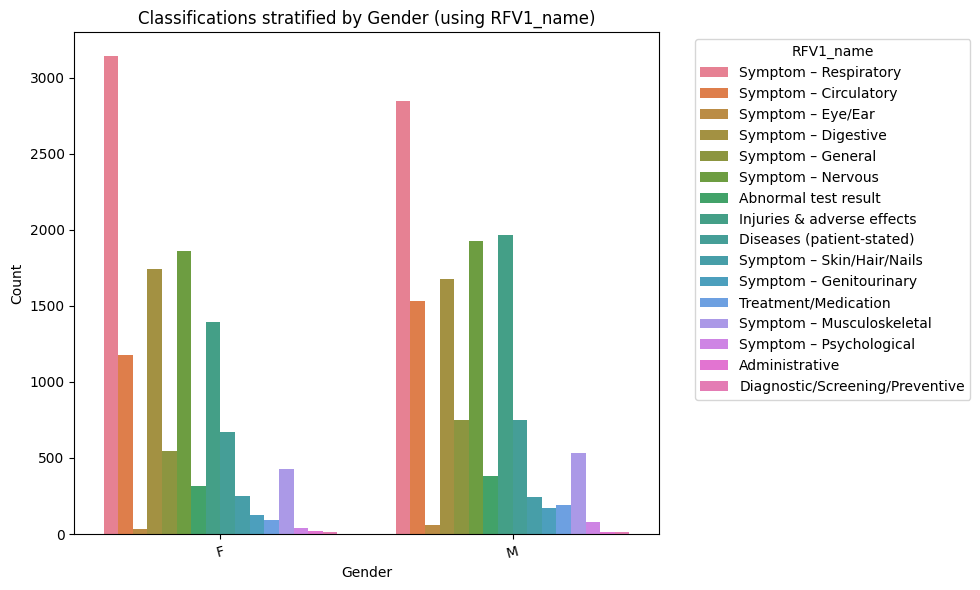

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values if any
plot_df = df.dropna(subset=['RFV1_name', 'gender'])

# Plot setup
plt.figure(figsize=(10,6))
sns.countplot(
    data=plot_df,
    x='gender',
    hue='RFV1_name'
)

# Formatting
plt.title("Classifications stratified by Gender (using RFV1_name)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(
    title="RFV1_name",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Create ordered age groups
age_bins  = [18, 40, 65, 80, float('inf')]
age_labels = ["18–39 (Young)", "40–64 (Middle-aged)", "65–79 (Older)", "80+ (Elderly)"]

data = df.copy()
data = data.dropna(subset=["age", "RFV1_name"])
data["age_group"] = pd.cut(data["age"], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

# (Optional) limit to top RFV categories to keep the figure readable
top_rfv = data["RFV1_name"].value_counts().head(12).index
plot_df = data[data["RFV1_name"].isin(top_rfv)]


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/321170315.py:16: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


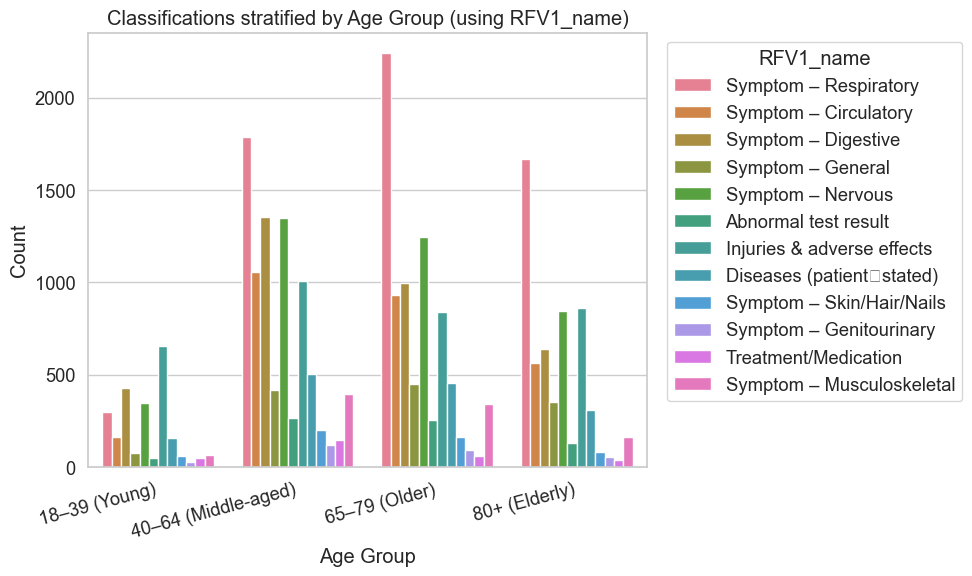

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns  # if not installed: %pip install seaborn

plt.figure(figsize=(10,6))
sns.countplot(
    data=plot_df,
    x="age_group",
    hue="RFV1_name",
    order=age_labels
)
plt.title("Classifications stratified by Age Group (using RFV1_name)")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/714717289.py:21: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


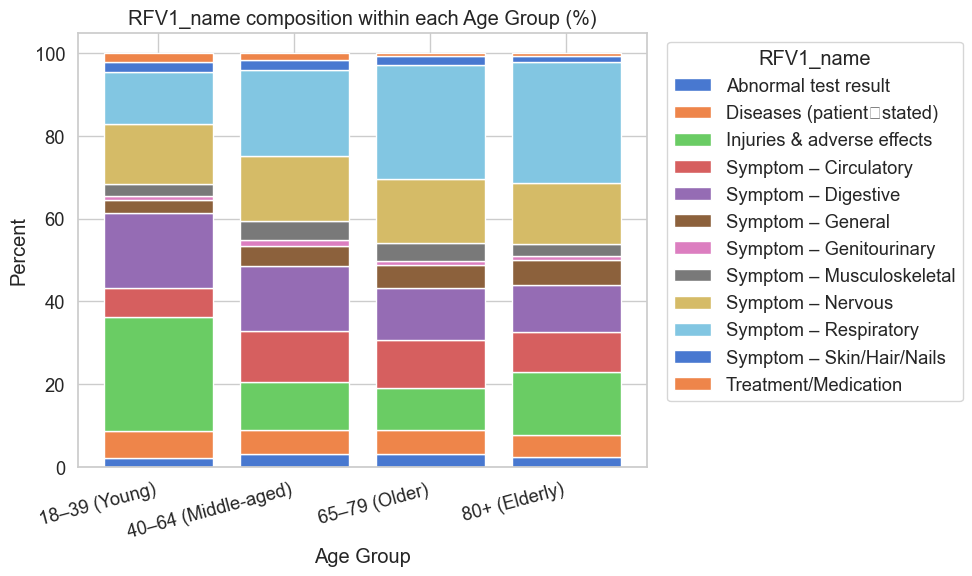

In [26]:
# Build % table: rows = age groups, columns = RFV1 categories
pct_tab = (
    pd.crosstab(plot_df["age_group"], plot_df["RFV1_name"], normalize="index")
    .mul(100)
    .reindex(index=age_labels)
)

plt.figure(figsize=(10,6))
# Stacked % bars with Matplotlib
bottom = None
for col in pct_tab.columns:
    vals = pct_tab[col].values
    plt.bar(pct_tab.index.astype(str), vals, bottom=bottom, label=col)
    bottom = vals if bottom is None else bottom + vals

plt.title("RFV1_name composition within each Age Group (%)")
plt.xlabel("Age Group")
plt.ylabel("Percent")
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

# Drop missing or unknown race entries
race_df = df.dropna(subset=['nih_race', 'RFV1_name']).copy()

# Optional: collapse rare races into 'Other' for readability
race_threshold = 20  # minimum count to keep category
race_counts = race_df['nih_race'].value_counts()
common_races = race_counts[race_counts >= race_threshold].index
race_df['race_group'] = race_df['nih_race'].apply(lambda x: x if x in common_races else 'Other')

# Restrict to top RFV1 categories (for readability)
top_rfv = race_df['RFV1_name'].value_counts().head(10).index
plot_df = race_df[race_df['RFV1_name'].isin(top_rfv)]


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/3562729163.py:15: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


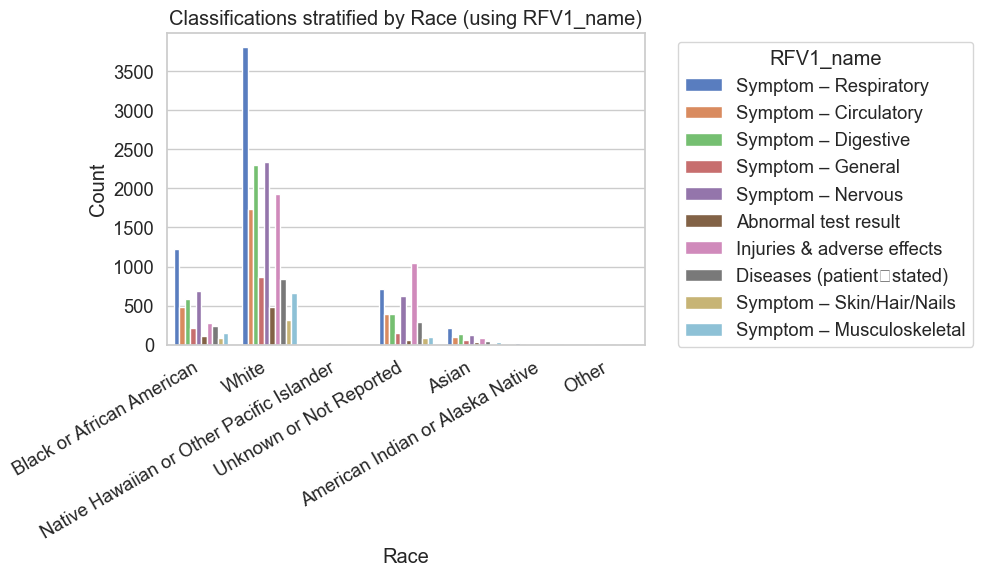

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns  # install if needed: %pip install seaborn

plt.figure(figsize=(10,6))
sns.countplot(
    data=plot_df,
    x='race_group',
    hue='RFV1_name'
)
plt.title("Classifications stratified by Race (using RFV1_name)")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/3557316472.py:21: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


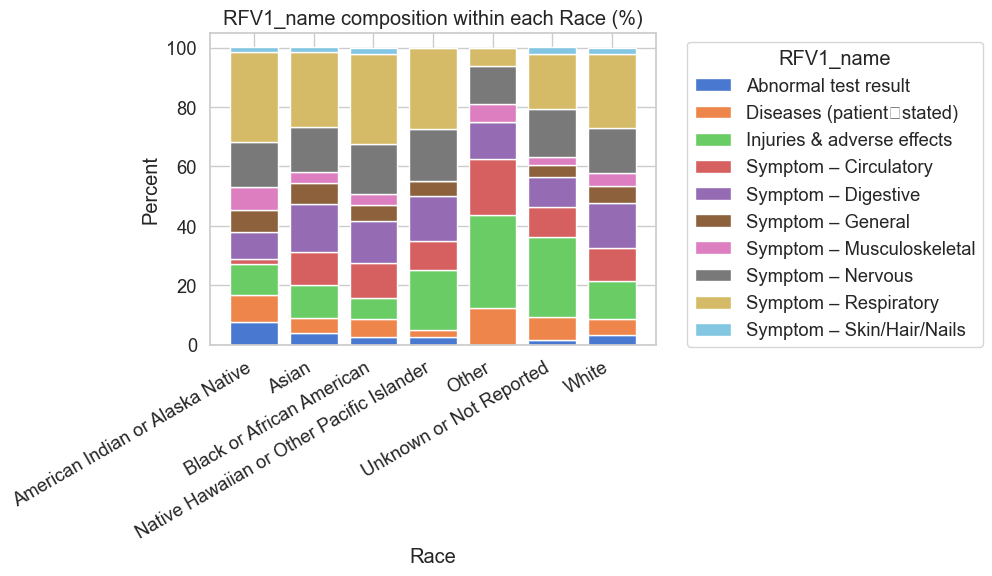

In [29]:
# Compute % distribution of RFV1_name within each race
pct_tab = (
    pd.crosstab(plot_df['race_group'], plot_df['RFV1_name'], normalize='index')
    .mul(100)
    .round(1)
)

# Plot as stacked % bars
plt.figure(figsize=(10,6))
bottom = None
for col in pct_tab.columns:
    vals = pct_tab[col].values
    plt.bar(pct_tab.index.astype(str), vals, bottom=bottom, label=col)
    bottom = vals if bottom is None else bottom + vals

plt.title("RFV1_name composition within each Race (%)")
plt.xlabel("Race")
plt.ylabel("Percent")
plt.xticks(rotation=30, ha='right')
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd

# Copy working dataset
data = df.copy()

# Ensure ICD columns exist
icd_cols = ["ICD10_J9602", "ICD10_J9612", "ICD10_J9622", "ICD10_J9692", "ICD10_E662", "ICD9_27803"]
for col in icd_cols:
    if col not in data.columns:
        data[col] = 0  # create empty if missing

# Classify by ICD diagnostic category
def classify_icd(row):
    if row["ICD10_J9602"] == 1:
        return "Acute RF with hypoxia"
    elif row["ICD10_J9612"] == 1:
        return "Acute RF with hypercapnia"
    elif row["ICD10_J9622"] == 1:
        return "Acute RF with hypoxia & hypercapnia"
    elif row["ICD10_J9692"] == 1:
        return "Respiratory failure, unspecified"
    elif row["ICD10_E662"] == 1 or row["ICD9_27803"] == 1:
        return "Obesity hypoventilation syndrome"
    else:
        return "Other / None"

data["icd_category"] = data.apply(classify_icd, axis=1)

# Quick summary
data["icd_category"].value_counts(dropna=False)


icd_category
Other / None                           25476
Acute RF with hypoxia                    793
Obesity hypoventilation syndrome         524
Acute RF with hypoxia & hypercapnia      386
Respiratory failure, unspecified         187
Acute RF with hypercapnia                 93
Name: count, dtype: int64

In [31]:
# Keep top RFV1_name categories for visibility
top_rfv = data["RFV1_name"].value_counts().head(10).index
plot_df = data[data["RFV1_name"].isin(top_rfv)]

# Cross-tab
tab_icd_rfv = pd.crosstab(plot_df["icd_category"], plot_df["RFV1_name"])
tab_icd_rfv_pct = pd.crosstab(plot_df["icd_category"], plot_df["RFV1_name"], normalize="index").mul(100).round(1)

display(tab_icd_rfv)
display(tab_icd_rfv_pct)


RFV1_name,Abnormal test result,Diseases (patient‑stated),Injuries & adverse effects,Symptom – Circulatory,Symptom – Digestive,Symptom – General,Symptom – Musculoskeletal,Symptom – Nervous,Symptom – Respiratory,Symptom – Skin/Hair/Nails
icd_category,,,,,,,,,,
Acute RF with hypercapnia,3,4,9,5,7,2,2,9,45,3
Acute RF with hypoxia,6,22,80,46,48,24,14,104,395,9
Acute RF with hypoxia & hypercapnia,9,10,15,19,17,8,9,38,241,3
Obesity hypoventilation syndrome,16,18,29,52,36,23,26,42,224,16
Other / None,661,1362,3199,2572,3293,1232,907,3560,5012,465
"Respiratory failure, unspecified",3,2,28,15,15,4,2,30,70,1


RFV1_name,Abnormal test result,Diseases (patient‑stated),Injuries & adverse effects,Symptom – Circulatory,Symptom – Digestive,Symptom – General,Symptom – Musculoskeletal,Symptom – Nervous,Symptom – Respiratory,Symptom – Skin/Hair/Nails
icd_category,,,,,,,,,,
Acute RF with hypercapnia,3.4,4.5,10.1,5.6,7.9,2.2,2.2,10.1,50.6,3.4
Acute RF with hypoxia,0.8,2.9,10.7,6.1,6.4,3.2,1.9,13.9,52.8,1.2
Acute RF with hypoxia & hypercapnia,2.4,2.7,4.1,5.1,4.6,2.2,2.4,10.3,65.3,0.8
Obesity hypoventilation syndrome,3.3,3.7,6.0,10.8,7.5,4.8,5.4,8.7,46.5,3.3
Other / None,3.0,6.1,14.4,11.6,14.8,5.5,4.1,16.0,22.5,2.1
"Respiratory failure, unspecified",1.8,1.2,16.5,8.8,8.8,2.4,1.2,17.6,41.2,0.6


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/3065910193.py:16: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


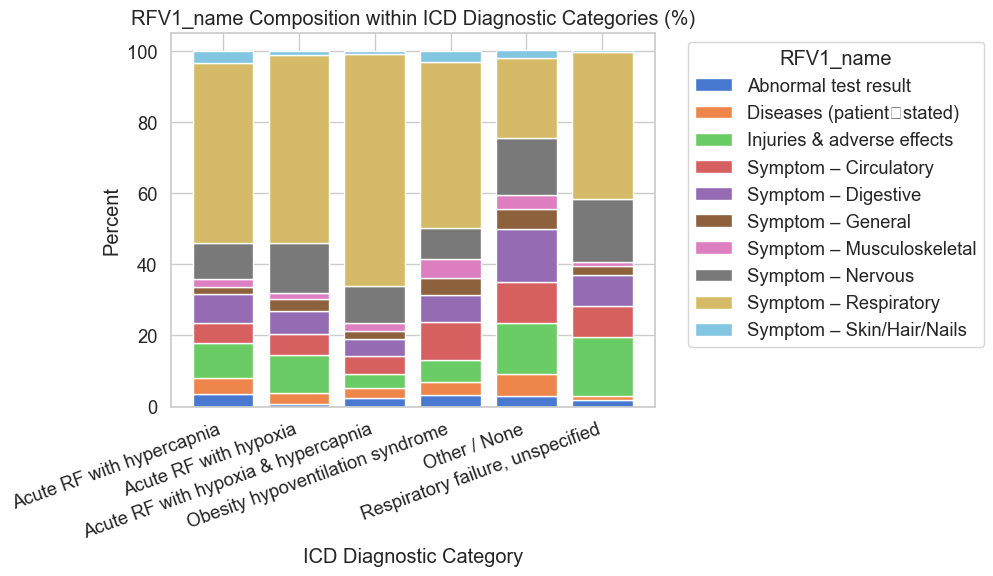

In [32]:
import matplotlib.pyplot as plt

# Stacked % bar plot
plt.figure(figsize=(10,6))
bottom = None
for col in tab_icd_rfv_pct.columns:
    vals = tab_icd_rfv_pct[col].values
    plt.bar(tab_icd_rfv_pct.index.astype(str), vals, bottom=bottom, label=col)
    bottom = vals if bottom is None else bottom + vals

plt.title("RFV1_name Composition within ICD Diagnostic Categories (%)")
plt.xlabel("ICD Diagnostic Category")
plt.ylabel("Percent")
plt.xticks(rotation=20, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

df["any_hypercap_icd"] = pd.to_numeric(df["any_hypercap_icd"], errors="coerce").fillna(0).astype(int)
df["pco2_threshold_any"] = pd.to_numeric(df["pco2_threshold_any"], errors="coerce").fillna(0).astype(int)

def inclusion_source(row):
    if row["any_hypercap_icd"] == 1 and row["pco2_threshold_any"] == 1:
        return "Both"
    elif row["any_hypercap_icd"] == 1:
        return "ICD_only"
    elif row["pco2_threshold_any"] == 1:
        return "Gas_only"
    else:
        return "Neither"

df["inclusion_type"] = df.apply(inclusion_source, axis=1)
df["inclusion_type"].value_counts()


inclusion_type
Gas_only    25476
Both         1663
ICD_only      320
Name: count, dtype: int64

In [38]:
# Ensure ICD columns are numeric (0/1)
icd_cols = ["ICD10_J9602", "ICD10_J9612", "ICD10_J9622", "ICD10_J9692", "ICD10_E662", "ICD9_27803"]

for col in icd_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Count how many rows have each ICD code = 1
icd_counts = {col: int(df[col].sum()) for col in icd_cols}

# Display cleanly
icd_summary = pd.DataFrame.from_dict(icd_counts, orient='index', columns=['Number of Patients'])
icd_summary


,Number of Patients
ICD10_J9602,793
ICD10_J9612,95
ICD10_J9622,412
ICD10_J9692,204
ICD10_E662,357
ICD9_27803,302


In [39]:
import pandas as pd

# Convert to numeric (0/1)
cols = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold", "pco2_threshold_any"]
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

# Count positive cases for each definition
counts = {c: int(df[c].sum()) for c in cols}
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['Number of Patients'])
counts_df['Percent'] = (counts_df['Number of Patients'] / len(df) * 100).round(1)
counts_df


,Number of Patients,Percent
any_hypercap_icd,1983,7.2
abg_hypercap_threshold,16806,61.2
vbg_hypercap_threshold,17422,63.4
pco2_threshold_any,27139,98.8


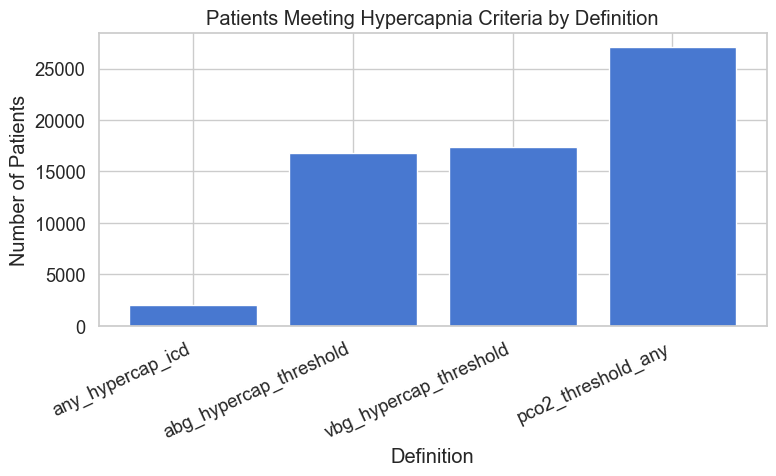

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(counts_df.index, counts_df['Number of Patients'])
plt.title('Patients Meeting Hypercapnia Criteria by Definition')
plt.ylabel('Number of Patients')
plt.xlabel('Definition')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd

# Make sure your key variables exist and are numeric
symptom_col = "RFV1_name"   # change if you’re using cc_cleaned_str or another NLP variable
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold", "pco2_threshold_any"]

for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Filter to top 10 symptom categories for readability
top_symptoms = df[symptom_col].value_counts().head(10).index
plot_df = df[df[symptom_col].isin(top_symptoms)]


In [42]:
summary_tables = {}
for c in criteria:
    tab = pd.crosstab(plot_df[symptom_col], plot_df[c], margins=False)
    tab.columns = ["No", "Yes"]
    tab["Percent_yes"] = (tab["Yes"] / tab.sum(axis=1) * 100).round(1)
    summary_tables[c] = tab.sort_values("Percent_yes", ascending=False)

# Display one example
summary_tables["pco2_threshold_any"].head(10)


,No,Yes,Percent_yes
RFV1_name,,,
Symptom – Nervous,23,3760,99.4
Symptom – Digestive,19,3397,99.4
Injuries & adverse effects,23,3337,99.3
Diseases (patient‑stated),11,1407,99.2
Abnormal test result,8,690,98.9
Symptom – General,14,1279,98.9
Symptom – Circulatory,32,2677,98.8
Symptom – Musculoskeletal,15,945,98.4
Symptom – Skin/Hair/Nails,10,487,98.0


In [8]:
# Identify the correct gender column
gender_col = [c for c in df.columns if c.lower().startswith("gender")][0]

# Frequency and percentage
gender_counts = df[gender_col].value_counts(dropna=False)
gender_percent = df[gender_col].value_counts(normalize=True, dropna=False) * 100

# Combine into one table
gender_summary = pd.DataFrame({
    "Count": gender_counts,
    "Percent": gender_percent.round(1)
})

print("=== Gender Distribution ===")
display(gender_summary)


=== Gender Distribution ===


,Count,Percent
gender,,
M,14522,52.9
F,12937,47.1


In [9]:
# List of your hypercapnia criteria
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold"]

# Convert to numeric (safety)
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Count and percentage
hypercap_summary = pd.DataFrame({
    "Count": [df[c].sum() for c in criteria],
    "Percent": [df[c].mean() * 100 for c in criteria]
}, index=criteria)

print("=== Hypercapnia Definition Prevalence ===")
display(hypercap_summary.round(2))


=== Hypercapnia Definition Prevalence ===


,Count,Percent
any_hypercap_icd,1983,7.22
abg_hypercap_threshold,16806,61.20
vbg_hypercap_threshold,17422,63.45


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/64239599.py:22: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


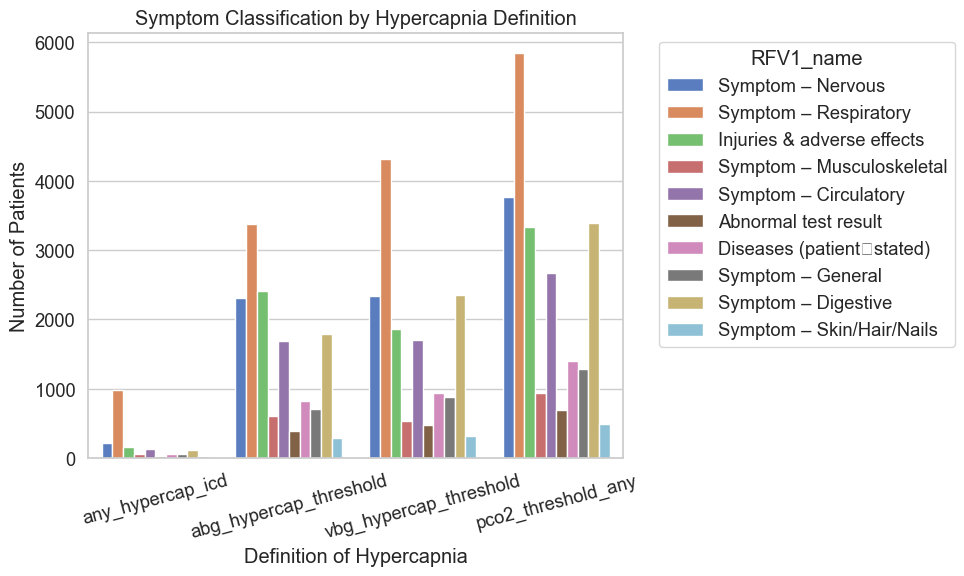

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt into long format for plotting
plot_melt = df.melt(id_vars=[symptom_col], value_vars=criteria,
                    var_name="Hypercapnia_Definition", value_name="Positive")
plot_melt = plot_melt[plot_melt[symptom_col].isin(top_symptoms)]
plot_melt = plot_melt[plot_melt["Positive"] == 1]

plt.figure(figsize=(10,6))
sns.countplot(
    data=plot_melt,
    x="Hypercapnia_Definition",
    hue=symptom_col,
    order=criteria
)
plt.title("Symptom Classification by Hypercapnia Definition")
plt.xlabel("Definition of Hypercapnia")
plt.ylabel("Number of Patients")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_2161/3588669245.py:19: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mac/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


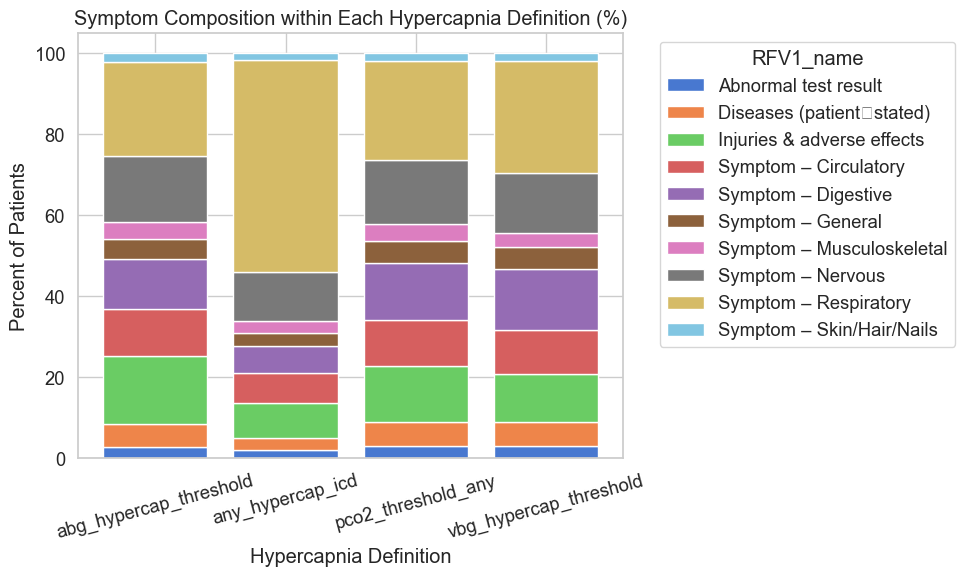

In [44]:
pct_tab = (
    pd.crosstab(plot_melt["Hypercapnia_Definition"], plot_melt[symptom_col], normalize="index")
    .mul(100)
    .round(1)
)

plt.figure(figsize=(10,6))
bottom = None
for col in pct_tab.columns:
    vals = pct_tab[col].values
    plt.bar(pct_tab.index, vals, bottom=bottom, label=col)
    bottom = vals if bottom is None else bottom + vals

plt.title("Symptom Composition within Each Hypercapnia Definition (%)")
plt.xlabel("Hypercapnia Definition")
plt.ylabel("Percent of Patients")
plt.xticks(rotation=15)
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# Load your dataset again
file_path = "2025-10-14 MIMICIV all with CC_with_NLP.xlsx"
df = pd.read_excel(file_path)

print("Data loaded successfully!")
print(df.shape)
df.head()


Data loaded successfully!
(27459, 123)


,hadm_id,subject_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,hosp_los_days,...,RFV3_support.1,RFV3_sim,RFV4.1,RFV4_name,RFV4_support.1,RFV4_sim,RFV5.1,RFV5_name,RFV5_support.1,RFV5_sim
0,22661627,10032409,2130-01-12 18:42:00,2130-01-21 14:32:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,8.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24424749,12063494,2161-06-02 18:45:00,2161-06-14 14:55:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,11.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22447711,13352386,2188-03-25 01:17:00,2188-03-26 16:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,1.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26316091,14588480,2124-11-05 03:16:00,2124-11-12 17:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,7.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22187856,14997275,2141-12-12 23:45:00,2141-12-14 14:45:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,1.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


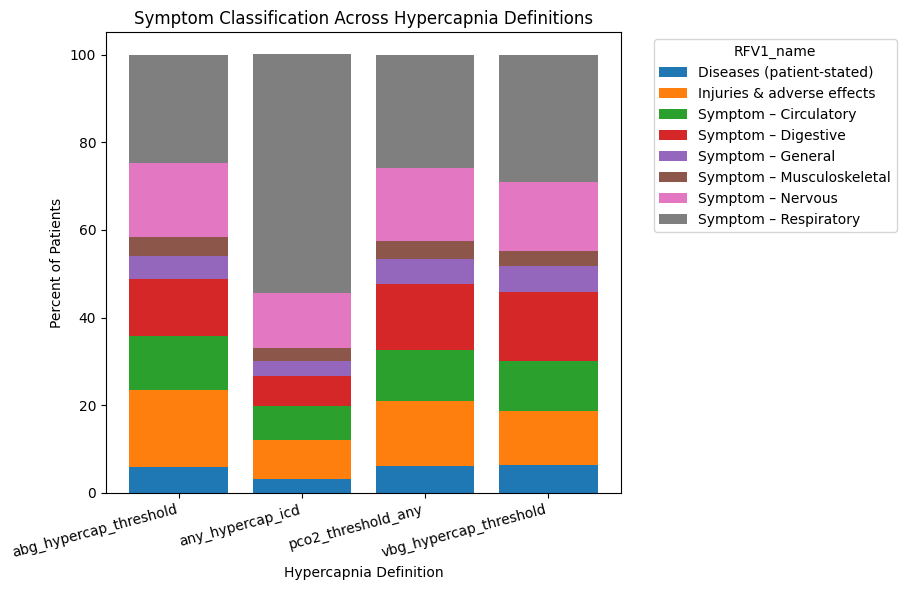

In [4]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

symptom_col = "RFV1_name"
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold", "pco2_threshold_any"]

# Ensure numeric
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Keep top symptom categories
top_symptoms = df[symptom_col].value_counts().head(8).index
plot_df = df[df[symptom_col].isin(top_symptoms)]

# Melt into long format (only positive cases)
melted = plot_df.melt(id_vars=[symptom_col], value_vars=criteria,
                      var_name="Definition", value_name="Positive")
melted = melted[melted["Positive"] == 1]

# Compute % composition per definition
pct_tab = (
    pd.crosstab(melted["Definition"], melted[symptom_col], normalize="index")
    .mul(100).round(1)
)

# Plot as stacked 100% bars
plt.figure(figsize=(9,6))
bottom = None
for col in pct_tab.columns:
    vals = pct_tab[col].values
    plt.bar(pct_tab.index, vals, bottom=bottom, label=col)
    bottom = vals if bottom is None else bottom + vals

plt.title("Symptom Classification Across Hypercapnia Definitions")
plt.xlabel("Hypercapnia Definition")
plt.ylabel("Percent of Patients")
plt.xticks(rotation=15, ha='right')
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


/var/folders/tg/s7g7dk553dn4cx7c81fx4z6c0000gn/T/ipykernel_1126/1034739116.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped["Percent"] = grouped["Count"] / grouped.groupby("AgeGroup")["Count"].transform("sum") * 100


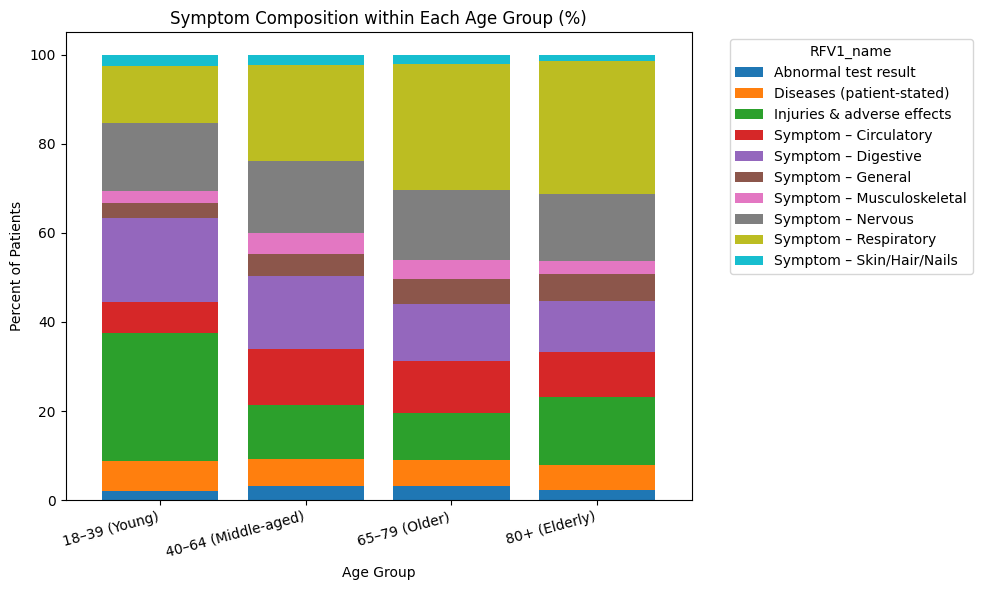

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Age groups (ordered)
bins   = [18, 40, 65, 80, np.inf]
labels = ["18–39 (Young)", "40–64 (Middle-aged)", "65–79 (Older)", "80+ (Elderly)"]
df = df.copy()
df = df.dropna(subset=["age", "RFV1_name"])
df["AgeGroup"] = pd.cut(df["age"], bins=bins, labels=labels, right=False, ordered=True)

# (Optional) keep top symptom classes for readability
top_k = 10
top_sym = df["RFV1_name"].value_counts().head(top_k).index
df_plot = df[df["RFV1_name"].isin(top_sym)]

# 2) Counts by AgeGroup × Symptom
grouped = (
    df_plot.groupby(["AgeGroup", "RFV1_name"], observed=True)
           .size()
           .reset_index(name="Count")
)

# 3) Percent within each AgeGroup — use transform to keep index aligned
grouped["Percent"] = grouped["Count"] / grouped.groupby("AgeGroup")["Count"].transform("sum") * 100

# 4) Pivot for plotting
pivot_df = grouped.pivot(index="AgeGroup", columns="RFV1_name", values="Percent").fillna(0)
pivot_df = pivot_df.reindex(index=labels)  # ensure desired order

# 5) Plot (stacked 100% bars)
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(10,6), width=0.8)
plt.title("Symptom Composition within Each Age Group (%)")
plt.ylabel("Percent of Patients")
plt.xlabel("Age Group")
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


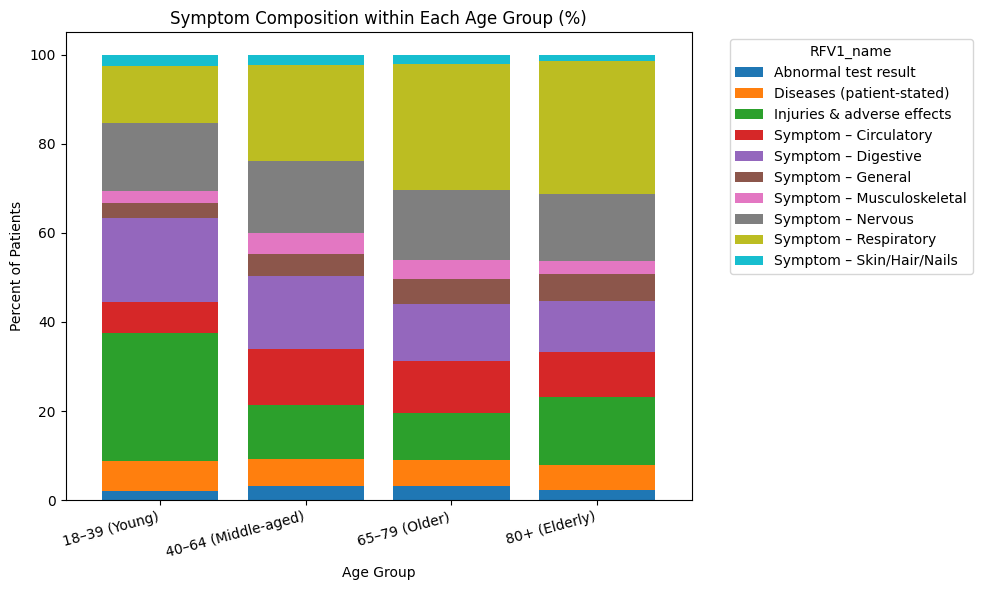

In [13]:
# Counts table
counts = pd.crosstab(df_plot["AgeGroup"], df_plot["RFV1_name"])

# Row-normalize to percentages
pct = counts.div(counts.sum(axis=1), axis=0).mul(100).fillna(0)

# Ensure age-group order
pct = pct.reindex(index=labels)

# Plot
ax = pct.plot(kind="bar", stacked=True, figsize=(10,6), width=0.8)
plt.title("Symptom Composition within Each Age Group (%)")
plt.ylabel("Percent of Patients")
plt.xlabel("Age Group")
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Text(0, 0.5, 'PaCO₂ (mmHg)')

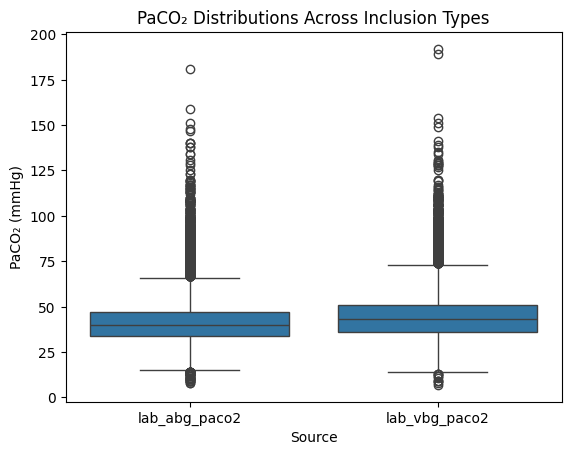

In [15]:
sns.boxplot(
    data=df.melt(id_vars=criteria, value_vars=['lab_abg_paco2','lab_vbg_paco2'], 
                 var_name='Source', value_name='PaCO2'),
    x='Source', y='PaCO2'
)
plt.title("PaCO₂ Distributions Across Inclusion Types")
plt.ylabel("PaCO₂ (mmHg)")


In [1]:
import statsmodels.api as sm
X = df[criteria]
y = df["is_respiratory"]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
sm.graphics.plot_partregress_grid(model)


ModuleNotFoundError: No module named 'statsmodels'

In [4]:
import numpy as np, pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- data prep
criteria = ["any_hypercap_icd","abg_hypercap_threshold","vbg_hypercap_threshold","pco2_threshold_any"]
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# robust flag for respiratory symptom
symptom_col = "RFV1_name"
df["is_respiratory"] = (
    df[symptom_col].astype(str).str.contains(r"\brespir", case=False, na=False)
).astype(int)

# design matrix and outcome
X = df[criteria]
y = df["is_respiratory"]
X = sm.add_constant(X, has_constant="add")

# --- fit logit
model = sm.Logit(y, X, missing="drop")
res = model.fit(disp=False)

# ORs with 95% CI
or_tab = pd.DataFrame({
    "OR": np.exp(res.params),
    "CI_lo": np.exp(res.conf_int()[0]),
    "CI_hi": np.exp(res.conf_int()[1]),
    "p": res.pvalues
}).round(3)

print("Adjusted odds of Respiratory presentation")
display(or_tab.loc[["any_hypercap_icd","abg_hypercap_threshold","vbg_hypercap_threshold","pco2_threshold_any"]])

# --- forest plot of ORs
plot = or_tab.loc[criteria]
ypos = np.arange(len(plot))[::-1]
plt.figure(figsize=(6,4))
plt.hlines(y=ypos, xmin=plot["CI_lo"], xmax=plot["CI_hi"])
plt.plot(plot["OR"], ypos, "o")
plt.vlines(1, ymin=-1, ymax=len(plot), linestyles="dashed")
plt.yticks(ypos, plot.index)
plt.xlabel("Odds ratio for Respiratory symptom")
plt.title("Adjusted ORs (95% CI)")
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [3]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "statsmodels"])


  Obtaining dependency information for statsmodels from https://files.pythonhosted.org/packages/5f/a5/fcc4f5f16355660ce7a1742e28a43e3a9391b492fc4ff29fdd6893e81c05/statsmodels-0.14.5-cp312-cp312-macosx_10_13_x86_64.whl.metadata
  Using cached statsmodels-0.14.5-cp312-cp312-macosx_10_13_x86_64.whl.metadata (9.5 kB)
  Obtaining dependency information for patsy>=0.5.6 from https://files.pythonhosted.org/packages/f1/70/ba4b949bdc0490ab78d545459acd7702b211dfccf7eb89bbc1060f52818d/patsy-1.0.2-py2.py3-none-any.whl.metadata
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.5-cp312-cp312-macosx_10_13_x86_64.whl (10.0 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


0

In [5]:
# --- Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you haven’t already:
# %pip install -U openpyxl statsmodels

# --- Load your dataset
file_path = "2025-10-14 MIMICIV all with CC_with_NLP.xlsx"  # adjust path if needed
df = pd.read_excel(file_path, engine="openpyxl")

print("Loaded:", df.shape)
# quick sanity check of key columns
need = ["RFV1_name","any_hypercap_icd","abg_hypercap_threshold","vbg_hypercap_threshold","pco2_threshold_any"]
print({c: (c in df.columns) for c in need})

# Ensure flags are numeric 0/1
criteria = ["any_hypercap_icd","abg_hypercap_threshold","vbg_hypercap_threshold","pco2_threshold_any"]
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Robust respiratory flag (matches anything containing 'respir')
symptom_col = "RFV1_name"
df["is_respiratory"] = (
    df[symptom_col].astype(str).str.strip().str.contains(r"\brespir", case=False, na=False)
).astype(int)

print("Respiratory cases:", int(df["is_respiratory"].sum()))


Loaded: (27459, 123)
{'RFV1_name': True, 'any_hypercap_icd': True, 'abg_hypercap_threshold': True, 'vbg_hypercap_threshold': True, 'pco2_threshold_any': True}
Respiratory cases: 5987


Adjusted odds of Respiratory presentation (vs not):


,OR,CI_lo,CI_hi,p
any_hypercap_icd,3.702,3.337,4.106,0.000
abg_hypercap_threshold,0.980,0.912,1.053,0.579
vbg_hypercap_threshold,1.575,1.455,1.704,0.000
pco2_threshold_any,0.875,0.672,1.139,0.321


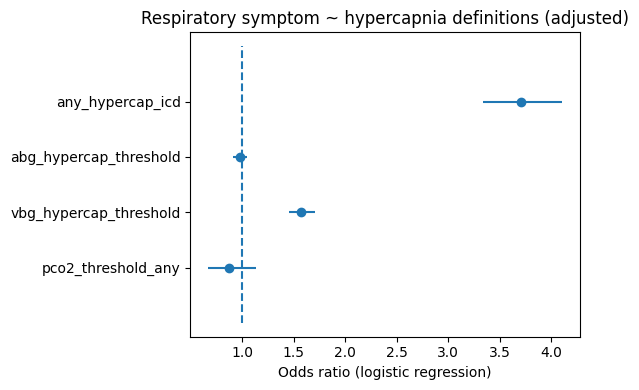

In [6]:
import statsmodels.api as sm

X = df[criteria].copy()
y = df["is_respiratory"]
X = sm.add_constant(X, has_constant="add")

model = sm.Logit(y, X, missing="drop")
res = model.fit(disp=False)

# Odds ratios with 95% CI
or_tab = pd.DataFrame({
    "OR": np.exp(res.params),
    "CI_lo": np.exp(res.conf_int()[0]),
    "CI_hi": np.exp(res.conf_int()[1]),
    "p": res.pvalues
}).round(3)

print("Adjusted odds of Respiratory presentation (vs not):")
display(or_tab.loc[criteria])

# Forest plot
plot = or_tab.loc[criteria]
ypos = np.arange(len(plot))[::-1]
plt.figure(figsize=(6,4))
plt.hlines(y=ypos, xmin=plot["CI_lo"], xmax=plot["CI_hi"])
plt.plot(plot["OR"], ypos, "o")
plt.vlines(1, ymin=-1, ymax=len(plot), linestyles="dashed")
plt.yticks(ypos, plot.index)
plt.xlabel("Odds ratio (logistic regression)")
plt.title("Respiratory symptom ~ hypercapnia definitions (adjusted)")
plt.tight_layout()
plt.show()


In [7]:
X = sm.add_constant(df[["any_hypercap_icd","pco2_threshold_any"]])
sm.Logit(y, X).fit(disp=False).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         is_respiratory   No. Observations:                27459
Model:                          Logit   Df Residuals:                    27456
Method:                           MLE   Df Model:                            2
Date:                Fri, 31 Oct 2025   Pseudo R-squ.:                 0.02748
Time:                        23:05:29   Log-Likelihood:                -14004.
converged:                       True   LL-Null:                       -14400.
Covariance Type:            nonrobust   LLR p-value:                1.432e-172
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6666      0.124    -13.450      0.000      -1.909      -1.424
any_hypercap_icd       1.4153      0.052     27.473      0.000       1.314       1.516
pco2_threshold_any     0.2597      0.123      2.113      0.035       0.019       0.501
======================================================================================
"""

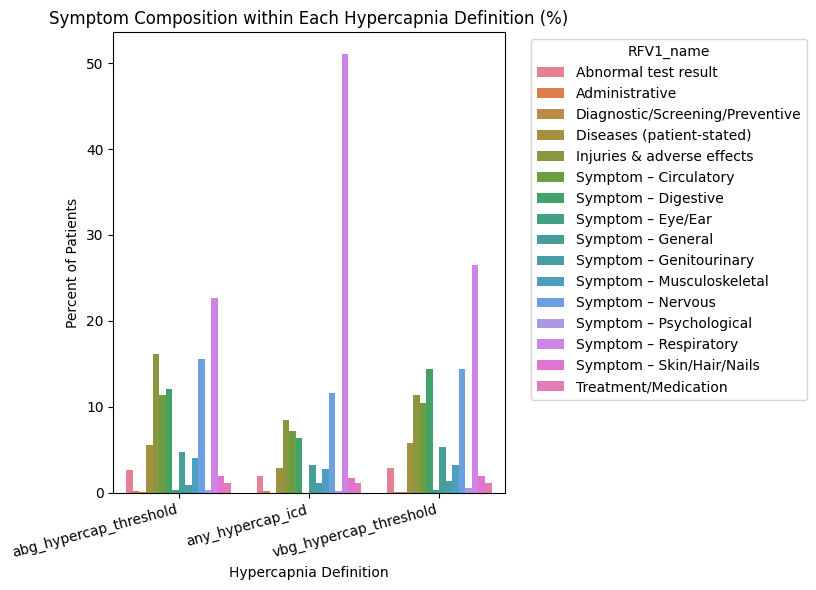

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Keep only these 3 definitions
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold"]

# Convert to numeric just in case
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Melt dataset into long format
plot_melt = df.melt(
    id_vars=["RFV1_name"],
    value_vars=criteria,
    var_name="Hypercapnia_Definition",
    value_name="Positive"
)

# Keep only positive (1) cases
plot_melt = plot_melt[plot_melt["Positive"] == 1]

# Calculate counts and percentages
grouped = (
    plot_melt.groupby(["Hypercapnia_Definition", "RFV1_name"])
    .size()
    .reset_index(name="Count")
)
# Compute percentage safely after resetting index
grouped["Percent"] = grouped.groupby("Hypercapnia_Definition")["Count"].transform(lambda x: 100 * x / x.sum())

# Plot stacked bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    data=grouped,
    x="Hypercapnia_Definition",
    y="Percent",
    hue="RFV1_name"
)
plt.title("Symptom Composition within Each Hypercapnia Definition (%)")
plt.ylabel("Percent of Patients")
plt.xlabel("Hypercapnia Definition")
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 900x600 with 0 Axes>

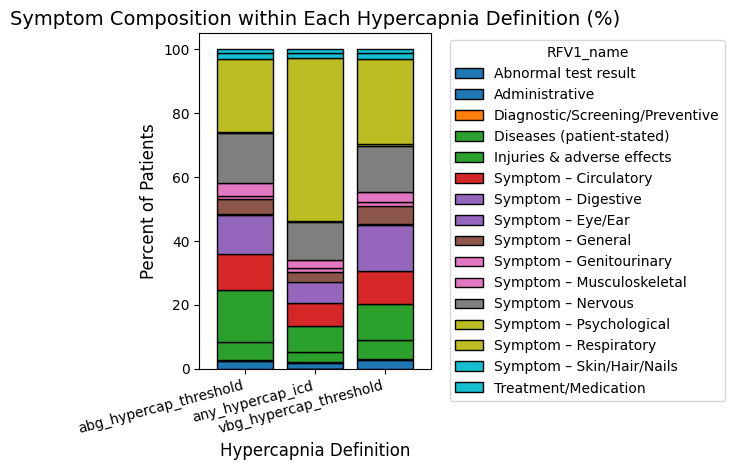

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Keep only these 3 hypercapnia definitions
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold"]

# Convert to numeric (safety)
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Melt into long format
plot_melt = df.melt(
    id_vars=["RFV1_name"],
    value_vars=criteria,
    var_name="Hypercapnia_Definition",
    value_name="Positive"
)

# Keep only positive (1) cases
plot_melt = plot_melt[plot_melt["Positive"] == 1]

# Calculate % within each definition
grouped = (
    plot_melt.groupby(["Hypercapnia_Definition", "RFV1_name"])
    .size()
    .reset_index(name="Count")
)
grouped["Percent"] = grouped.groupby("Hypercapnia_Definition")["Count"].transform(lambda x: 100 * x / x.sum())

# Pivot so each RFV1_name becomes a column → required for stacking
pivot_df = grouped.pivot(index="Hypercapnia_Definition", columns="RFV1_name", values="Percent").fillna(0)

# Plot stacked bars
plt.figure(figsize=(9, 6))
pivot_df.plot(
    kind="bar",
    stacked=True,
    colormap="tab10",
    width=0.8,
    edgecolor="black"
)

# Formatting
plt.title("Symptom Composition within Each Hypercapnia Definition (%)", fontsize=14)
plt.ylabel("Percent of Patients", fontsize=12)
plt.xlabel("Hypercapnia Definition", fontsize=12)
plt.xticks(rotation=15, ha="right")
plt.legend(title="RFV1_name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [13]:
# Reuse the same grouped dataset logic
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold"]

# Convert to numeric (safety)
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Melt long format
plot_melt = df.melt(
    id_vars=["RFV1_name"],
    value_vars=criteria,
    var_name="Hypercapnia_Definition",
    value_name="Positive"
)

# Keep only positive (1)
plot_melt = plot_melt[plot_melt["Positive"] == 1]

# Count + Percent
summary_table = (
    plot_melt.groupby(["Hypercapnia_Definition", "RFV1_name"])
    .size()
    .reset_index(name="Count")
)

summary_table["Percent"] = summary_table.groupby("Hypercapnia_Definition")["Count"].transform(
    lambda x: 100 * x / x.sum()
)

# Sort by definition then descending count
summary_table = summary_table.sort_values(["Hypercapnia_Definition", "Count"], ascending=[True, False])

# Round for clean display
summary_table["Percent"] = summary_table["Percent"].round(1)

# Display nicely
display(summary_table)


,Hypercapnia_Definition,RFV1_name,Count,Percent
13,abg_hypercap_threshold,Symptom – Respiratory,3377,22.7
4,abg_hypercap_threshold,Injuries & adverse effects,2406,16.2
11,abg_hypercap_threshold,Symptom – Nervous,2316,15.6
6,abg_hypercap_threshold,Symptom – Digestive,1790,12.0
5,abg_hypercap_threshold,Symptom – Circulatory,1690,11.4
3,abg_hypercap_threshold,Diseases (patient‑stated),828,5.6
8,abg_hypercap_threshold,Symptom – General,715,4.8
10,abg_hypercap_threshold,Symptom – Musculoskeletal,607,4.1
0,abg_hypercap_threshold,Abnormal test result,388,2.6
14,abg_hypercap_threshold,Symptom – Skin/Hair/Nails,296,2.0


In [14]:
# --- Create the summary table (same as before) ---
criteria = ["any_hypercap_icd", "abg_hypercap_threshold", "vbg_hypercap_threshold"]

# Ensure numeric
for c in criteria:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

# Melt to long format
plot_melt = df.melt(
    id_vars=["RFV1_name"],
    value_vars=criteria,
    var_name="Hypercapnia_Definition",
    value_name="Positive"
)

# Keep positives only
plot_melt = plot_melt[plot_melt["Positive"] == 1]

# Count + Percent
summary_table = (
    plot_melt.groupby(["Hypercapnia_Definition", "RFV1_name"])
    .size()
    .reset_index(name="Count")
)
summary_table["Percent"] = summary_table.groupby("Hypercapnia_Definition")["Count"].transform(
    lambda x: 100 * x / x.sum()
)
summary_table["Percent"] = summary_table["Percent"].round(1)

# Sort neatly
summary_table = summary_table.sort_values(["Hypercapnia_Definition", "Count"], ascending=[True, False])

# --- Export to Excel ---
output_path = "Symptom_Composition_by_Hypercapnia_Definition.xlsx"
summary_table.to_excel(output_path, index=False)

print(f"✅ Exported successfully to {output_path}")


✅ Exported successfully to Symptom_Composition_by_Hypercapnia_Definition.xlsx


In [15]:
pivot_ready = grouped.pivot_table(
    index="RFV1_name",
    columns="Hypercapnia_Definition",
    values="Percent",
    fill_value=0
).round(1)

pivot_ready.to_excel("Symptom_Composition_Pivot_ChartReady.xlsx")
print("✅ Exported chart-ready pivot table for Excel plotting.")


✅ Exported chart-ready pivot table for Excel plotting.


In [22]:
# Calculate counts and proportions
counts = (
    plot_melt.groupby(["Hypercapnia_Definition", "RFV1_name"])
    .size()
    .reset_index(name="Count")
)

# Denominator per Hypercapnia group
denoms = counts.groupby("Hypercapnia_Definition")["Count"].sum().rename("Total")

# Merge back to compute proportions
counts = counts.merge(denoms, on="Hypercapnia_Definition")
counts["Proportion"] = counts["Count"] / counts["Total"]


In [23]:
import numpy as np

# Compute 95% CI (Wald approximation)
counts["CI_lower"] = counts["Proportion"] - 1.96 * np.sqrt(
    (counts["Proportion"] * (1 - counts["Proportion"])) / counts["Total"]
)
counts["CI_upper"] = counts["Proportion"] + 1.96 * np.sqrt(
    (counts["Proportion"] * (1 - counts["Proportion"])) / counts["Total"]
)

# Convert to %
counts["Percent"] = counts["Proportion"] * 100
counts["CI_lower"] = counts["CI_lower"] * 100
counts["CI_upper"] = counts["CI_upper"] * 100


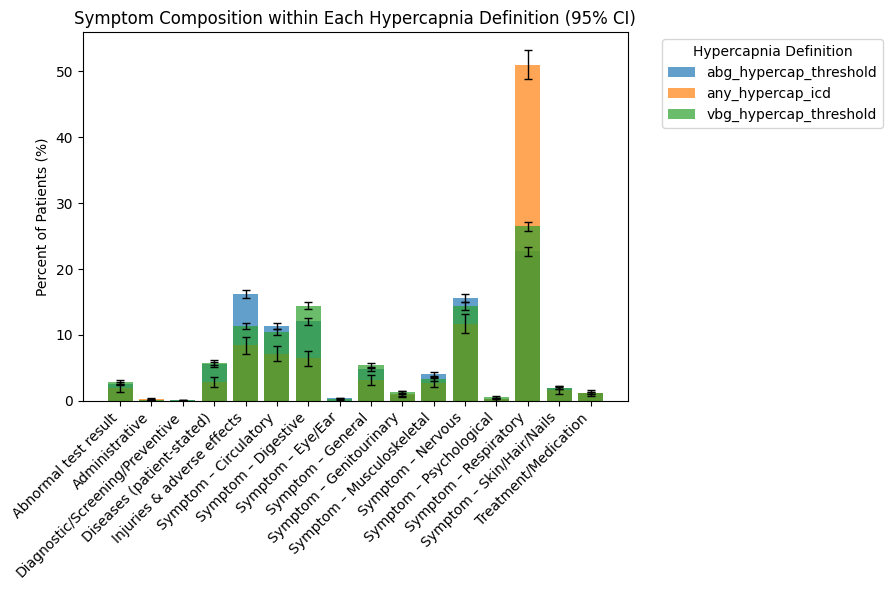

In [24]:
plt.figure(figsize=(9, 6))
for i, defn in enumerate(counts["Hypercapnia_Definition"].unique()):
    subset = counts[counts["Hypercapnia_Definition"] == defn]
    plt.bar(
        subset["RFV1_name"],
        subset["Percent"],
        label=defn,
        alpha=0.7
    )
    # Add 95% CI as error bars
    plt.errorbar(
        subset["RFV1_name"],
        subset["Percent"],
        yerr=[
            subset["Percent"] - subset["CI_lower"],
            subset["CI_upper"] - subset["Percent"]
        ],
        fmt="none",
        ecolor="black",
        elinewidth=1,
        capsize=3
    )

plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent of Patients (%)")
plt.title("Symptom Composition within Each Hypercapnia Definition (95% CI)")
plt.legend(title="Hypercapnia Definition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


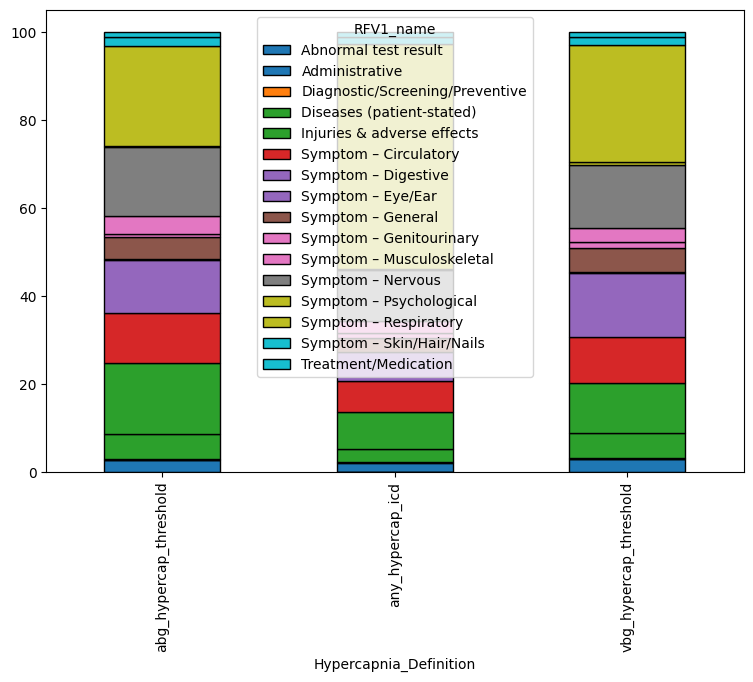

In [25]:
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(9,6), colormap="tab10", edgecolor="black")

# Add error bars manually
for p in ax.patches:
    x = p.get_x() + p.get_width()/2
    height = p.get_height()
    y = p.get_y() + height
    # Add line for CI if available
    ci_data = counts[(counts["Hypercapnia_Definition"] == p.get_x())]  # adjust indexing logic as needed
    # plt.errorbar(x, y, yerr=..., fmt="none", ecolor="black", elinewidth=1, capsize=2)
